In [ ]:
import glob
import os
import lxml.etree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import defaultdict, Counter
import xml.etree.ElementTree as ET
import re
from collections import defaultdict
from lxml import etree
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
import matplotlib.patches as mpatches

## Extracting Structured Data from ParlaMint-PT (TEI XML)

In this step, we read a collection of TEI XML files (which store speeches from Portugal’s Parliament), extract useful information (like who spoke, when, and what they said), and turn it into a structured table using pandas

In [44]:
# Set path to your ParlaMint data
DATA_PATH = '/Users/elisaonder/Desktop/ParlaMint-PT.TEI'


In [45]:
# Path to your TEI files
tei_path = r"/Users/elisaonder/Desktop/ParlaMint-PT.TEI"

# Load speaker metadata if listPerson.xml exists
speakers_dict = {}
persons_file = os.path.join(tei_path, "ParlaMint-PT-listPerson.xml")
if os.path.exists(persons_file):
    tree = ET.parse(persons_file)
    root = tree.getroot()
    for person in root.findall(".//{*}person"):
        pid = person.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

        # Full name, clean whitespace and join all text parts
        name_el = person.find(".//{*}persName")
        name = " ".join(name_el.itertext()).replace("\n", " ").split() if name_el is not None else pid
        name = " ".join(name)

        # Gender
        sex_el = person.find(".//{*}sex")
        gender = sex_el.attrib.get("value") if sex_el is not None else "Unknown"

        # Party
        affil_el = person.find(".//{*}affiliation")
        party_id = affil_el.attrib.get("ref", "Unknown") if affil_el is not None else "Unknown"
        party_name_el = affil_el.find(".//{*}orgName") if affil_el is not None else None
        party_name = party_name_el.text.strip() if party_name_el is not None else party_id

        speakers_dict[pid] = {
            "name": name,
            "gender": gender,
            "party_id": party_id,
            "party_name": party_name
        }

# Find all session XML files
files = glob.glob(os.path.join(tei_path, "20*/**/*.xml"), recursive=True)
print(f"Found {len(files)} XML files.")

data = []

for f in files:
    if "Schema" in f:
        continue  # Skip schema files

    try:
        tree = ET.parse(f)
        root = tree.getroot()

        # Session metadata
        session_id = root.attrib.get("{http://www.w3.org/XML/1998/namespace}id", os.path.basename(f))
        session_title_el = root.find(".//{*}title")
        session_title = session_title_el.text.strip() if session_title_el is not None and session_title_el.text else "Unknown"

        # Extract year from session_id (ParlaMint-PT_YYYY-MM-DD)
        try:
            year = session_id.split("_")[1].split("-")[0]
        except:
            year = "Unknown"

        # Date: fallback to <date> if available
        date_el = root.find(".//{*}date")
        if date_el is not None and date_el.attrib.get("when"):
            session_date = date_el.attrib.get("when")
        else:
            # Use session_id date if <date> is missing
            session_date = "_".join(session_id.split("_")[1:])

        # Utterances
        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

            speaker_id = u.attrib.get("who")
            speaker_id = speaker_id.lstrip("#") if speaker_id else "Unknown"

            speech_type = u.attrib.get("ana", "Unknown")
            lang = u.attrib.get("{http://www.w3.org/XML/1998/namespace}lang", "pt")

            # Get speaker info
            speaker_info = speakers_dict.get(
                speaker_id,
                {"name": speaker_id, "gender": "Unknown", "party_id": "Unknown", "party_name": "Unknown"}
            )

            # Combine <seg> text
            text = " ".join(seg.text.strip() for seg in u.findall(".//{*}seg") if seg.text)
            word_count = len(text.split())

            data.append([
                speech_id, session_id, session_title, session_date, year,
                speaker_id, speaker_info["name"], speaker_info["party_id"], speaker_info["party_name"],
                speaker_info["gender"], speech_type, lang,
                word_count, text
            ])

    except Exception as e:
        print(f"⚠️ Error parsing {f}: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=[
    "speech_id", "session_id", "session_title", "date", "year",
    "speaker_id", "speaker_name", "party_id", "party_name",
    "gender", "speech_type", "language",
    "word_count", "text"
])

# Preview
print(df.head(10))

# Optionally save to CSV
# df.to_csv("ParlaMint_PT_corpus_all_years.csv", index=False)

Found 901 XML files.
                     speech_id               session_id  \
0   ParlaMint-PT_2022-06-02.u1  ParlaMint-PT_2022-06-02   
1   ParlaMint-PT_2022-06-02.u2  ParlaMint-PT_2022-06-02   
2   ParlaMint-PT_2022-06-02.u3  ParlaMint-PT_2022-06-02   
3   ParlaMint-PT_2022-06-02.u4  ParlaMint-PT_2022-06-02   
4   ParlaMint-PT_2022-06-02.u5  ParlaMint-PT_2022-06-02   
5   ParlaMint-PT_2022-06-02.u6  ParlaMint-PT_2022-06-02   
6   ParlaMint-PT_2022-06-02.u7  ParlaMint-PT_2022-06-02   
7   ParlaMint-PT_2022-06-02.u8  ParlaMint-PT_2022-06-02   
8   ParlaMint-PT_2022-06-02.u9  ParlaMint-PT_2022-06-02   
9  ParlaMint-PT_2022-06-02.u10  ParlaMint-PT_2022-06-02   

                                       session_title        date  year  \
0  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2022   
1  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2022   
2  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2022   
3  Corpus parlamentar português P

This part of the code enriches the dataset by detecting non-verbal events that occur during parliamentary speeches, such as applause, laughter, shouts, and interruptions.
It works by scanning each utterance (`<u>`) in the TEI-XML files and looking for `<vocal>` or `<incident>` elements. These elements are then normalized into consistent categories (e.g., “applause,” “laughter,” “shout,” “interruption”).  
For each speech, the code counts how many times these events occur and stores the results in a new DataFrame (events_df).  
Finally, this new information is merged with the main dataset (df) to create df_enriched, which now contains both the original speech content and the additional event counts.

In [46]:
# Collect per-speech non-verbal events
event_counts = defaultdict(Counter)
event_texts  = defaultdict(list)

def normalize_label(v_type, v_text):
    """Map TEI <vocal>/<incident> to normalized labels."""
    vt = (v_type or "").lower()
    vx = (v_text or "").lower()
    # Portuguese & English cues
    if any(k in vt for k in ["applause", "aplauso", "aplausos"]) or any(k in vx for k in ["aplaus", "aplauso"]):
        return "applause"
    if any(k in vt for k in ["laughter", "risos", "riso"]) or any(k in vx for k in ["risos", "riso", "laughter"]):
        return "laughter"
    if any(k in vt for k in ["shout", "boo", "cheer", "aclama"]) or any(k in vx for k in ["grito", "gritos", "apupos", "aclama"]):
        return "shout"
    if any(k in vt for k in ["interrupt"]) or any(k in vx for k in ["interrup"]):
        return "interruption"
    return None

for f in files:
    if "Schema" in f:
        continue
    try:
        tree = ET.parse(f)
        root = tree.getroot()

        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")
            if not speech_id:
                continue

            # <vocal> (applause, laughter, shouts, etc.)
            for voc in u.findall(".//{*}vocal"):
                v_type = voc.attrib.get("type") or voc.attrib.get("ana")
                v_text = "".join(voc.itertext()).strip()
                label = normalize_label(v_type, v_text)
                if label:
                    event_counts[speech_id][label] += 1
                    # Only show readable markers for key labels
                    if label in ("applause", "laughter", "shout"):
                        event_texts[speech_id].append(f"[{label.capitalize()}]")
                else:
                    event_counts[speech_id]["vocal_other"] += 1

            # <incident> (interruptions, noise, etc.)
            for inc in u.findall(".//{*}incident"):
                i_type = inc.attrib.get("type") or inc.attrib.get("ana")
                i_text = "".join(inc.itertext()).strip()
                label = normalize_label(i_type, i_text)
                if label == "interruption":
                    event_counts[speech_id]["interruption"] += 1
                    event_texts[speech_id].append("[Interruption]")
                else:
                    event_counts[speech_id]["incident_other"] += 1

    except Exception as e:
        print(f"⚠️ Error scanning events in {f}: {e}")

# Build a DataFrame with event counts and markers
events_df = pd.DataFrame(
    [
        {
            "speech_id": sid,
            "applause_count": cnts.get("applause", 0),
            "laughter_count": cnts.get("laughter", 0),
            "shout_count": cnts.get("shout", 0),
            "interruption_count": cnts.get("interruption", 0),
            "vocal_other_count": cnts.get("vocal_other", 0),
            "incident_other_count": cnts.get("incident_other", 0),
            "events_text": " ".join(event_texts[sid]),
        }
        for sid, cnts in event_counts.items()
    ]
)

# Merge with your existing df, keep original columns intact
df_enriched = df.merge(events_df, on="speech_id", how="left")

# Fill NaNs for new columns and create a convenience text with events
for col in ["applause_count","laughter_count","shout_count",
            "interruption_count","vocal_other_count","incident_other_count"]:
    if col in df_enriched.columns:
        df_enriched[col] = df_enriched[col].fillna(0).astype(int)

df_enriched["events_text"] = df_enriched["events_text"].fillna("")
df_enriched["text_with_events"] = (
    df_enriched["text"].fillna("") + " " + df_enriched["events_text"]
).str.strip()

# Quick peek
print(df_enriched[["speech_id","speaker_name","party_name",
                   "applause_count","laughter_count","shout_count","interruption_count",
                   "text_with_events"]].head(10))


                     speech_id                                   speaker_name  \
0   ParlaMint-PT_2022-06-02.u1                   Augusto Ernesto Santos Silva   
1   ParlaMint-PT_2022-06-02.u2      Pedro Saraiva Gonçalves dos Santos Frazão   
2   ParlaMint-PT_2022-06-02.u3               António Filipe Dias Melo Peixoto   
3   ParlaMint-PT_2022-06-02.u4      Pedro Saraiva Gonçalves dos Santos Frazão   
4   ParlaMint-PT_2022-06-02.u5  Maria Antónia Moreno Areias de Almeida Santos   
5   ParlaMint-PT_2022-06-02.u6      Pedro Saraiva Gonçalves dos Santos Frazão   
6   ParlaMint-PT_2022-06-02.u7                   Augusto Ernesto Santos Silva   
7   ParlaMint-PT_2022-06-02.u8                   Joana Rita Madaleno Cordeiro   
8   ParlaMint-PT_2022-06-02.u9                    Rodrigo Miguel Dias Saraiva   
9  ParlaMint-PT_2022-06-02.u10                   Joana Rita Madaleno Cordeiro   

  party_name  applause_count  laughter_count  shout_count  interruption_count  \
0        #PS               

## Overview of the Dataset

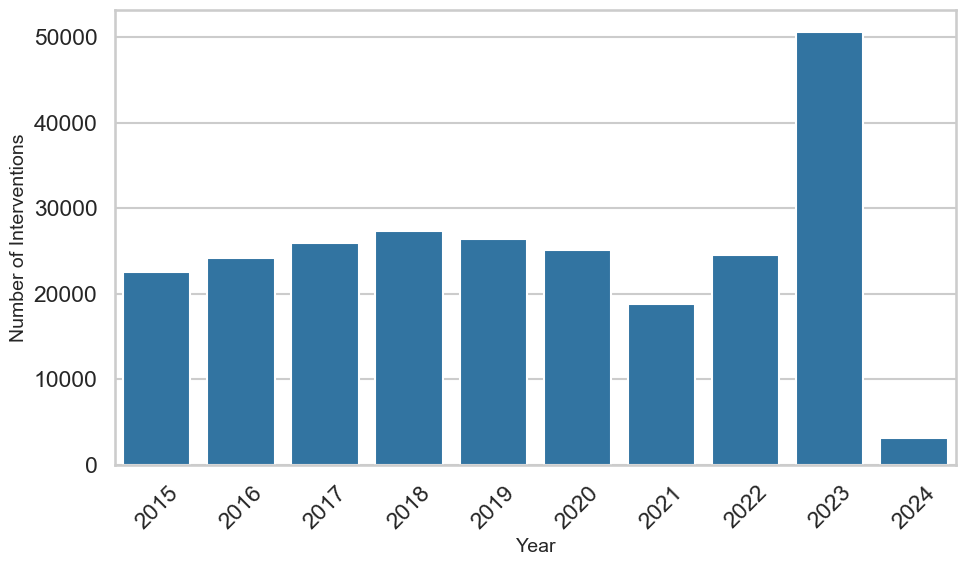

In [47]:
# Set Seaborn style
sns.set(style="whitegrid", context="talk")

# Graph 1: Number of speeches per year
plt.figure(figsize=(10,6))
speech_counts = df.groupby('year')['speech_id'].count().sort_index()

sns.barplot(
    x=speech_counts.index,
    y=speech_counts.values,
    color="#1f77b4"
)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Interventions", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*Interpretation:*

The graph shows the speech distribution from 2015 until 13th of March 2024. In the histogram we can see that in 2023 is substatially higher than in all other years. In 2024, we only have the speeches for the first two and half months, that is why the count of speeches is lower.

### Factors Behind the 2023 Spike in Parliamentary Speeches

In [48]:
session_counts = df.groupby("year")["session_id"].nunique()
print(session_counts)


year
2015     98
2016    103
2017    107
2018    111
2019     97
2020     91
2021     90
2022     78
2023    117
2024      9
Name: session_id, dtype: int64


So the spike in speeches in 2023 is at least partly explained by the fact that there were more parliamentary sessions that year.  The increase in the number of speeches in 2023 is strongly linked to the number of parliamentary sessions held that year. Our dataset records 117 unique sessions in 2023, compared to around 90–110 in earlier years.

In [49]:
speeches_per_session = df.groupby(["year","session_id"])["speech_id"].count().groupby("year").mean()
print(speeches_per_session)

year
2015    230.622449
2016    234.388350
2017    242.514019
2018    246.144144
2019    271.731959
2020    275.758242
2021    209.122222
2022    314.256410
2023    432.905983
2024    347.555556
Name: speech_id, dtype: float64


When normalizing the data by the number of sessions per year, we find that 2023 still shows an exceptional increase. On average, each parliamentary session in 2023 contained over 430 speeches, compared to around 230–250 per session in the mid-2010s. This means that the rise in 2023 cannot be explained only by a higher number of sessions; sessions themselves became far more speech-intensive.  

The political landscape in 2023 was marked by significant instability:

- **Prime Minister's Resignation:** In November 2023, Prime Minister António Costa resigned amid a corruption investigation involving several government officials. This event led to the dissolution of parliament and the call for early elections ([AP News](https://apnews.com/article/935d9f33c9e5179e920dc7e1bcd95eea)).

- **Snap Election and Government Formation:** A snap election was held on March 10, 2024, resulting in a fragmented parliament. The centre-right Democratic Alliance (AD), led by Luís Montenegro, won the most seats but fell short of a majority. The far-right Chega party emerged as the main opposition, overtaking the Socialist Party for the first time ([The Guardian](https://www.theguardian.com/world/2025/may/28/far-right-chega-party-becomes-main-opposition-in-portugals-parliament)).

These political upheavals likely led to more frequent debates, motions, and speeches in parliament as parties navigated the crisis and engaged in intense discussions.
By contrast, years such as 2021, with only ~209 speeches per session, suggest quieter or shorter parliamentary sittings, possibly influenced by the COVID-19 pandemic.


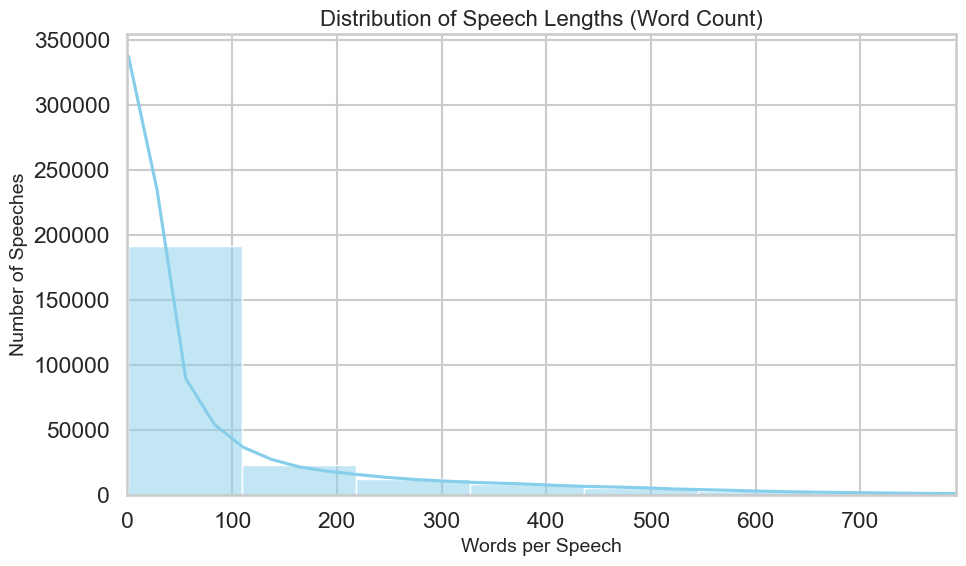

In [50]:
# Graph 2: Distribution of speech lengths
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Speech Lengths (Word Count)", fontsize=16)
plt.xlabel("Words per Speech", fontsize=14)
plt.ylabel("Number of Speeches", fontsize=14)
plt.xlim(0, df['word_count'].quantile(0.99))  # limit x-axis to 99th percentile to avoid long tails
plt.tight_layout()
plt.show()

*Interpretation:*

The distribution of speech lenght (word count) is positively skewed. In the graph we can se that the speech lenght for the majority of the speeches is only 100 words. That “pile-up around ~100 words” is mostly an artifact, not a real “most speeches are ~100 words” fact. A few things are happening at once:
- Parliaments have tons of very short interventions (procedural remarks, “Aplausos.”, heckles). Those dominate the counts and create a huge first few bins.
- Your bins are wide and the x-axis is truncated at P99, so a lot of mass gets squeezed toward the left visually.

Therefore, we ploted the graph below.

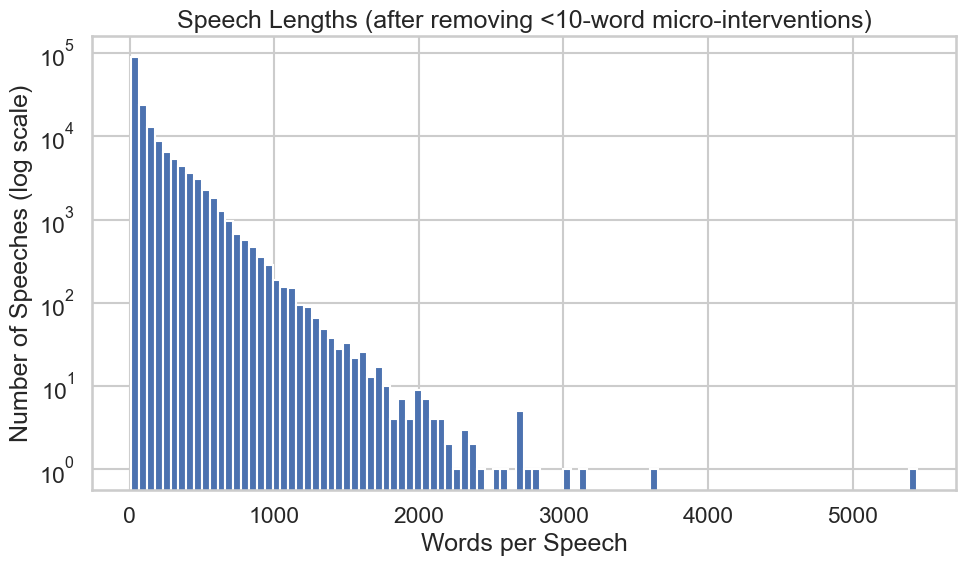

In [51]:
#  Graph 2.1: Distribution of speech lengths (after removing <10-word micro-interventions) 

# 1) sanity check the distribution
df['word_count'].describe(percentiles=[.5, .75, .9, .95, .99])

# Look at examples of ultra-short "speeches"
df.loc[df['word_count'] <= 5, 'text'].head(20)

# 2) simple cleaning: drop ultra-short micro-interventions
df_clean = df[df['word_count'] >= 10].copy()

# 3) use narrower bins and log Y to handle skew; avoid KDE
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_clean['word_count'], bins=100)
plt.yscale('log')                        # log count helps you see the tail
plt.title("Speech Lengths (after removing <10-word micro-interventions)")
plt.xlabel("Words per Speech")
plt.ylabel("Number of Speeches (log scale)")
plt.tight_layout()
plt.show()

*Interpretation:*

Key features of the new plot:
- Log scale on Y-axis: Instead of the first few bins dwarfing everything, you now see the entire shape of the distribution. Most speeches are still short (a few dozen to a few hundred words), but you can also see the long right tail of speeches that go into the thousands of words.
- Removed <10-word micro-interventions: This filters out “noise” like applause markers or one-liner heckles that aren’t meaningful speeches. That’s why the huge spike at very low word counts disappeared.
- Heavy-tailed / approximately power-law behavior: The straight-ish line on the log plot indicates that very long speeches become exponentially rarer, but they do exist (some >5000 words).

Differences with the previous graph:
- Previous graph (linear scale, included micro-speeches):
    - Huge spike at very low word counts made it look like “most speeches are ~100 words.”
    - KDE curve was misleading, smoothing over a very discrete, skewed distribution.
    - The long tail was invisible because everything was crushed to the left.
- New graph (log scale, micro-speeches removed):
    - Shows the true shape: many short speeches, fewer medium-length, and a very long but small tail.
    - You can now distinguish between short interventions (10–200 words), typical speeches (200–1000), and rare marathon speeches (>2000).
    - It’s interpretable for both central tendency and extremes.


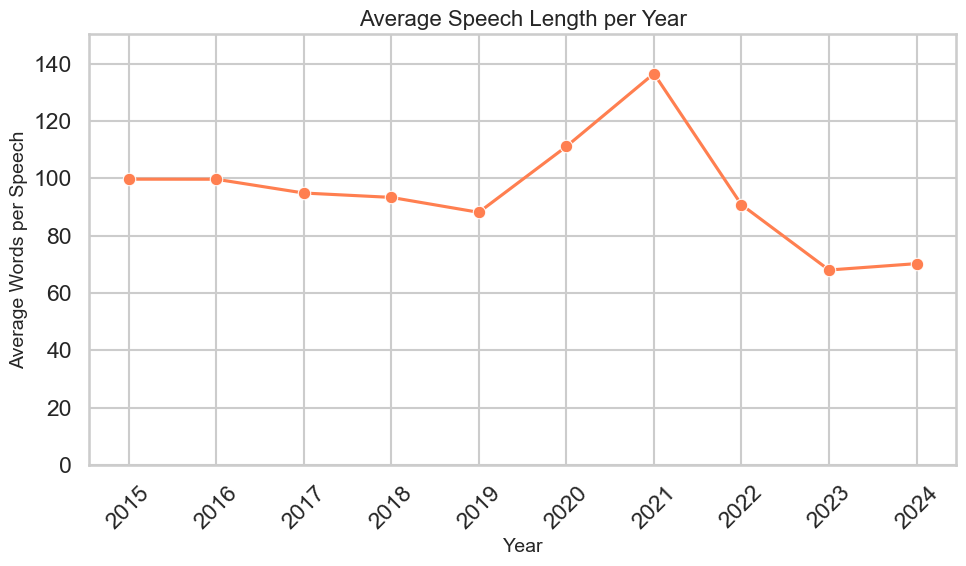

In [52]:
#  Graph 3: Compute average speech length per year 

avg_length = df.groupby('year')['word_count'].mean().sort_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=avg_length.index, y=avg_length.values, marker="o", color="coral")
plt.title("Average Speech Length per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Words per Speech", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, avg_length.max()*1.1)  # Add a little space above max
plt.tight_layout()
plt.show()

*Interpretation:*

- Stable period (2015–2019): Suggests normal parliamentary routines, with average speeches being short interventions.

- Spike in 2020–2021: A significant increase in average speech length occurred during these years. This surge is primarily attributed to:

  - **COVID-19 Pandemic:** The pandemic necessitated extensive legislative debates on public health measures, emergency laws, and economic relief packages. These complex topics led to longer speeches as parliamentarians engaged in detailed discussions and deliberations.

  - **State of Emergency Decrees:** The government invoked emergency powers to manage the crisis, prompting debates on constitutional and legal implications, further extending speech durations.


- Decline after 2021: Average speech lengths drop significantly. As the immediate crisis abated, parliamentary sessions likely returned to standard procedures with shorter interventions.

These trends underscore the significant influence of external events, such as a global health crisis, on parliamentary discourse and the dynamics of legislative proceedings.


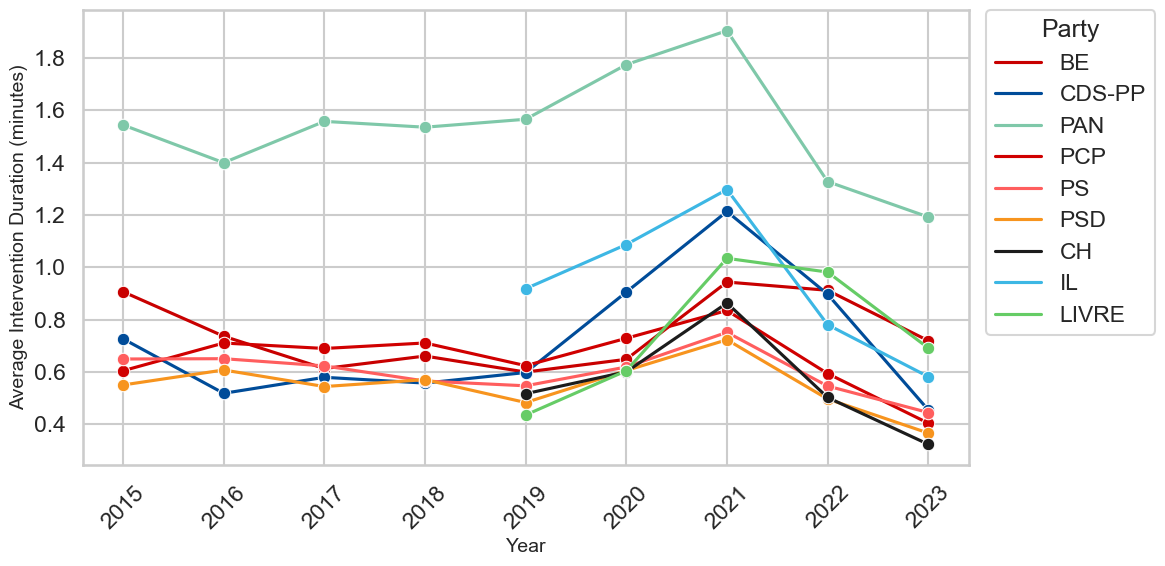

In [53]:
# Graph 4: Average Speech Duration per Year by Party (specified parties) excluding 2024

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

party_colors = {
    "PS": "#FF5E5E",
    "PSD": "#F7941E",
    "CDS-PP": "#004C99",
    "BE": "#C80000",
    "PCP": "#D00000",
    "PEV": "#009933",
    "IL": "#3DB7E4",
    "CHEGA": "#1C1C1C",
    "PAN": "#7FC8A9",
    "LIVRE": "#66CC66",
}

sns.set(style="whitegrid", context="talk")

df["minutes"] = df["word_count"] / 150

avg_minutes_by_party_year = (
    df.groupby(["year", "party_name"])["minutes"]
      .mean()
      .reset_index()
)

target_parties = [
    "BE", "#BE",
    "PCP", "#PCP",
    "LIVRE", "#LIVRE", "L", "#L",
    "PS", "#PS",
    "PAN", "#PAN",
    "PSD", "#PSD",
    "IL", "#IL",
    "CDS-PP", "#CDS-PP",
    "CH", "#CH", "CHEGA", "#CHEGA"
]

plot_data = avg_minutes_by_party_year[
    avg_minutes_by_party_year["party_name"].isin(target_parties)
].copy()

# Make year numeric and drop 2024 robustly
plot_data["year_num"] = pd.to_numeric(plot_data["year"], errors="coerce")
plot_data = plot_data[plot_data["year_num"] < 2024].copy()

# Build palette that matches the exact labels in plot_data["party_name"]
palette = {}
for p in plot_data["party_name"].unique():
    base = p.lstrip("#")

    if base == "CH":
        base_key = "CHEGA"
    elif base == "L":
        base_key = "LIVRE"
    else:
        base_key = base

    if base_key in party_colors:
        palette[p] = party_colors[base_key]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=plot_data,
    x="year_num",
    y="minutes",
    hue="party_name",
    marker="o",
    palette=palette
)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Intervention Duration (minutes)", fontsize=14)
plt.xticks(rotation=45)

handles, labels = plt.gca().get_legend_handles_labels()
clean_labels = []
for lab in labels:
    lab2 = lab.lstrip("#")
    if lab2 == "L":
        lab2 = "LIVRE"
    if lab2 == "CHEGA":
        lab2 = "CH"
    clean_labels.append(lab2)

plt.legend(
    handles,
    clean_labels,
    title="Party",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()


*Interpretation:*
- BE: Starts as the party with longest speeches (2015), then declines, rises again in 2020–2021, and stabilizes around ~0.8 min by 2024.
- CDS-PP: The most dramatic swing — from ~0.7 min in 2015 to 1.2 min peak in 2021, then collapsing in 2023, but strongly rebounding in 2024.
- PCP: Fairly stable until 2019, rises in 2020–2021 (~0.7–0.8 min), but then declines sharply to ~0.35 min by 2024.
- PS & PSD: Similar trajectories — steady until 2019, rise in 2020–2021, sharp fall after 2021, modest recovery in 2024 (but still below 2015–2017 levels).
- Chega (CH): Enters in 2019 with ~0.6 min, follows the general peak in 2020–2021, but then declines steeply, reaching the shortest average speech length (0.3 min) in 2024.

In [54]:
print(df['party_name'].value_counts().head(10))  # most frequent parties
print(df['gender'].value_counts())

#PS        87370
#PSD       54551
#PCP       29051
#BE        25945
#CDS-PP    22195
#CH        12670
#IL         6036
#PEV        3782
#PAN        3624
#L          2047
Name: party_name, dtype: int64
M    185825
F     62752
Name: gender, dtype: int64


Looking at party representation, the Socialist Party (PS) is the most frequent, with 87,370 speeches, indicating it is heavily represented in the parliament or has highly active speakers.
Regarding gender, there are 185,825 speeches by men and 62,752 by women, showing that men dominate parliamentary speech activity in this dataset, reflecting both historical gender composition and differences in speaking frequency.

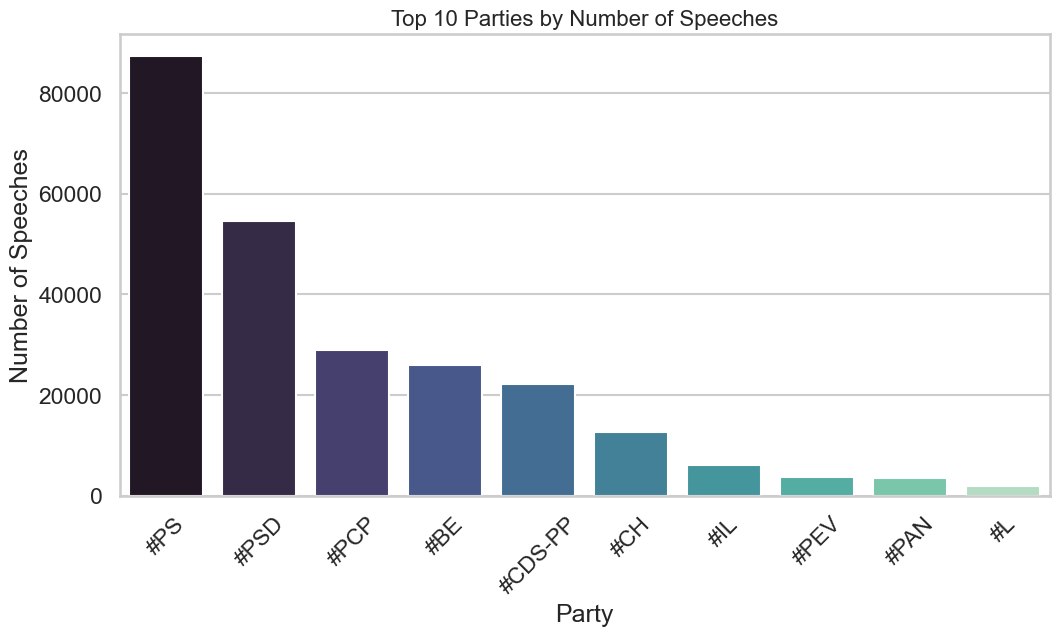

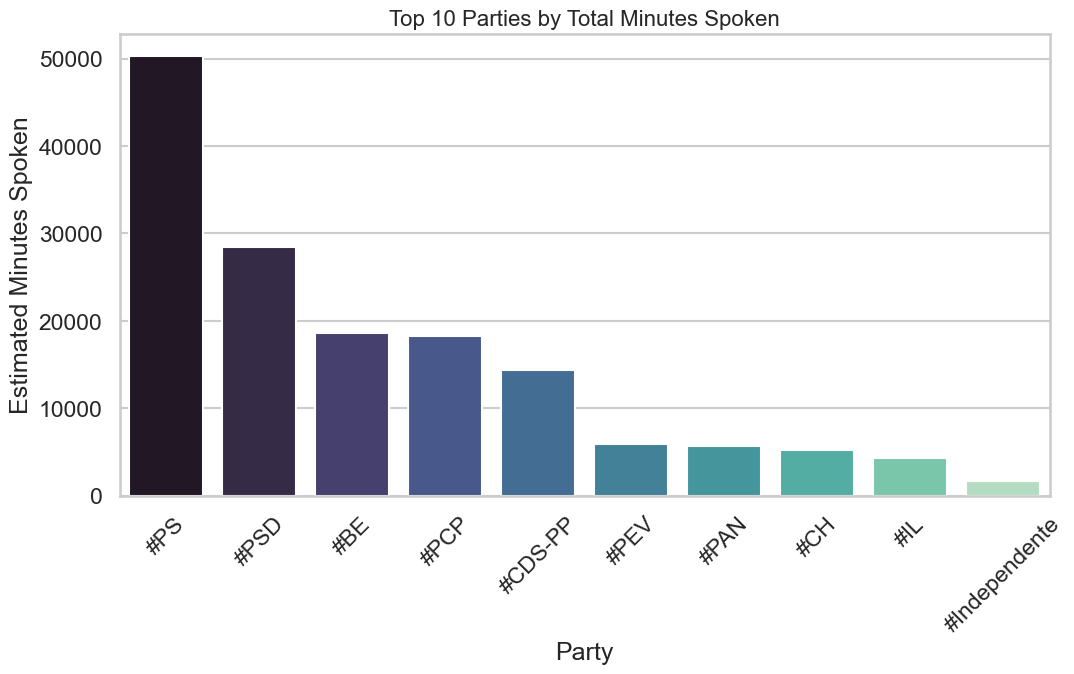

In [55]:
#  Graph 5: Top 10 parties by number of speeches 
plt.figure(figsize=(12,6))
party_counts = df['party_name'].value_counts().head(10)  # top 10 parties
sns.barplot(x=party_counts.index, y=party_counts.values, palette="mako")
plt.title("Top 10 Parties by Number of Speeches", fontsize=16)
plt.ylabel("Number of Speeches")
plt.xlabel("Party")
plt.xticks(rotation=45)
plt.show()

# Add column for estimated minutes
df['minutes'] = df['word_count'] / 150

# Sum minutes by party
party_minutes = df.groupby('party_name')['minutes'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=party_minutes.index, y=party_minutes.values, palette="mako")
plt.title("Top 10 Parties by Total Minutes Spoken", fontsize=16)
plt.ylabel("Estimated Minutes Spoken")
plt.xlabel("Party")
plt.xticks(rotation=45)
plt.show()

*Interpretation:*

The graph show the top 10 Portuguese parties by number of speeches and minutes spoken in the parliament. Mostly the parties in both graphs match.

The distribution of speeches closely tracks party size and parliamentary influence: larger and governing parties (PS, PSD) dominate, mid-sized ideological parties (PCP, BE, CDS-PP) take a significant share, and newcomers (CH, IL) are punching above their historical weight given their short time in parliament.

Chega stands out: although it only entered in 2019, it has already overtaken older small parties (PEV, PAN, Livre) in number of speeches by far, but not by number of minutes spoken, signaling that it has frequent short interventions.

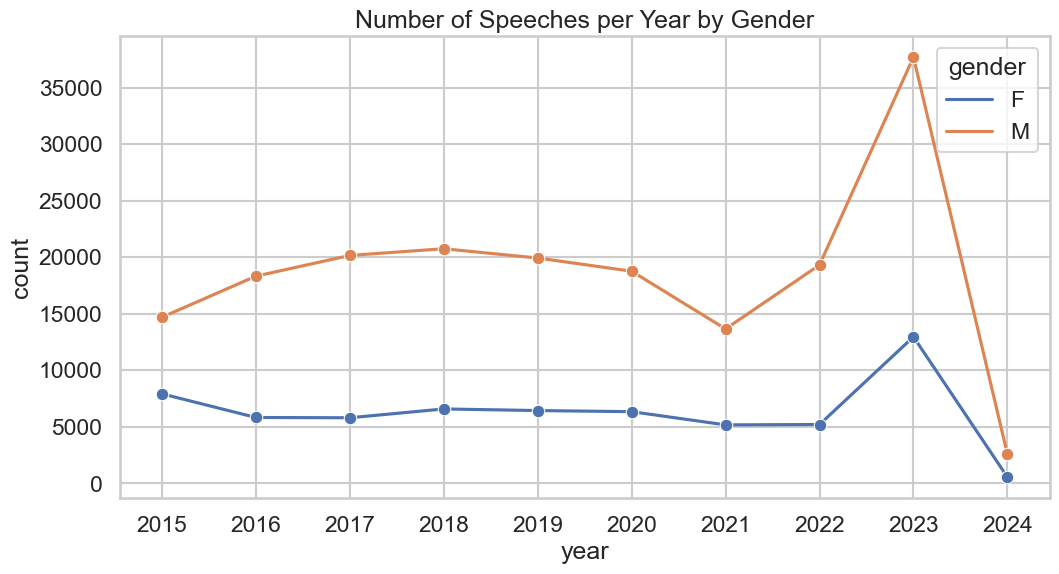

In [56]:
gender_by_year = df.groupby(['year','gender']).size().reset_index(name='count')
plt.figure(figsize=(12,6))
sns.lineplot(data=gender_by_year, x='year', y='count', hue='gender', marker="o")
plt.title("Number of Speeches per Year by Gender")
plt.show()

*Interpretation:*

- There is an overall imbalance.
- Male MPs (M) consistently deliver far more speeches than female MPs (F) throughout the period.
- The gap is very wide: usually ~3x more male speeches than female speeches.  

This disparity likely reflects a combination of factors, including the historically higher proportion of male representatives in the Portuguese Parliament, differences in seniority or leadership positions that afford more speaking opportunities

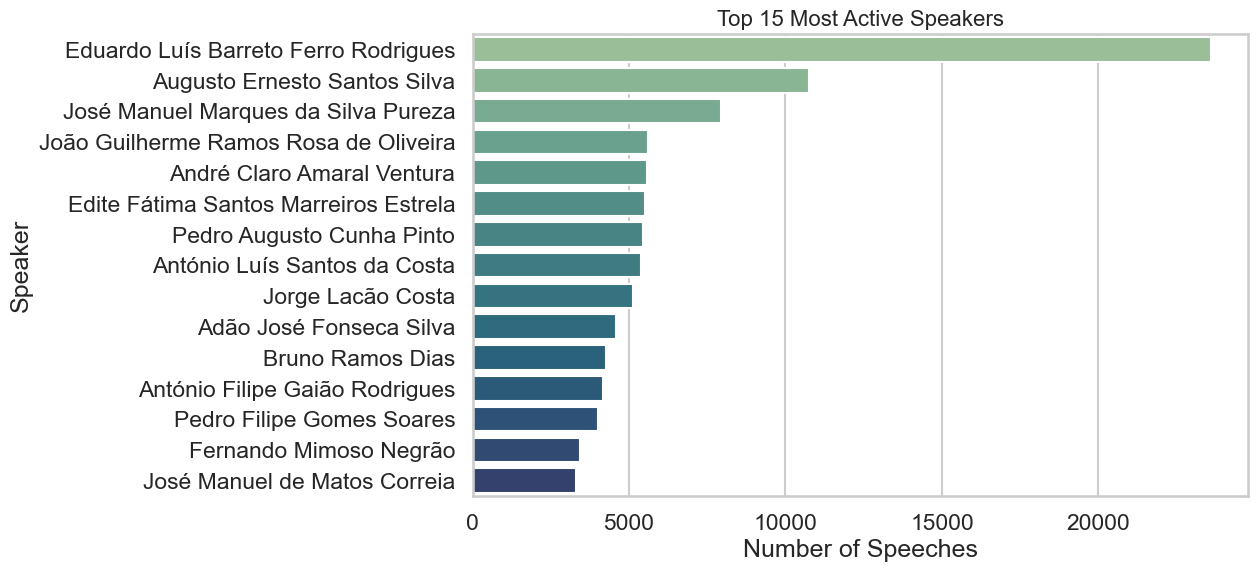

In [57]:
top_speakers = df['speaker_name'].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="crest")
plt.title("Top 15 Most Active Speakers", fontsize=16)
plt.xlabel("Number of Speeches")
plt.ylabel("Speaker")
plt.show()


*Interpretation:*

The ranking reflects not just political activism but also institutional role + leadership status + career length. Ferro Rodrigues’ huge lead highlights how the Speaker of Parliament, by moderating nearly every session, becomes by far the most frequent “speaker” in raw counts.

- Institutional roles drive speech counts: Presidents of the Assembly and government leaders (e.g., Ferro Rodrigues, Santos Silva, António Costa) dominate due to procedural interventions and frequent participation.
- Party leaders stand out: Figures like André Ventura (CH), António Costa (PS), and Pedro Filipe Soares (BE) use speeches strategically to assert leadership and visibility.
- Longevity matters: MPs with long parliamentary careers accumulate high totals over time, explaining why many of these names are senior figures.

## Chega Deepdive


In [58]:
sns.set(style="whitegrid", context="talk")

# Minutes ≈ words / 150 (speech rate)
if 'minutes' not in df.columns:
    df['minutes'] = df['word_count'] / 150.0

# Clean year for sorting
df['year_num'] = pd.to_numeric(df['year'], errors='coerce')

# Robust Chega filter (party_id or party_name can be '#CH' / 'CH' / 'Chega')
is_ch = (
    df['party_id'].str.upper().str.contains('CH', na=False) |
    df['party_name'].str.upper().str.contains('CHEGA|^#CH$', na=False)
)
ch = df[is_ch].copy()

print(f"Total speeches: {len(df):,} | Chega speeches: {len(ch):,}")

Total speeches: 248,577 | Chega speeches: 12,670


Chega accounts for 12,670 speeches out of a total of 248,577, which represents roughly 5% of all speeches in the dataset. This is a relatively small share compared to larger, long-established parties like the Socialist Party (PS).  
The figure reflects Chega’s recent entry into Portuguese politics (founded in 2019, first parliamentary seat in 2019, significant breakthrough in 2022). Because of this, the party has had fewer representatives and fewer opportunities to intervene in parliamentary debates compared to older parties with larger parliamentary groups.  
However, the presence of more than twelve thousand speeches in a short period also indicates that Chega has been highly active in debates relative to its size, consistent with its strategy of making itself visible and shaping parliamentary discourse through frequent interventions.

### 1: How big is Chega’s presence? (counts, minutes, shares)

 year_num  total_speeches  total_minutes  ch_speeches  ch_minutes  share_speeches_%  share_minutes_%  ch_avg_minutes
     2015           22601       15022.27          0.0        0.00              0.00             0.00            0.00
     2016           24142       16043.19          0.0        0.00              0.00             0.00            0.00
     2017           25949       16412.27          0.0        0.00              0.00             0.00            0.00
     2018           27322       17002.25          0.0        0.00              0.00             0.00            0.00
     2019           26358       15485.95        135.0       69.87              0.51             0.45            0.52
     2020           25094       18587.25        921.0      553.67              3.67             2.98            0.60
     2021           18821       17132.30        526.0      454.51              2.79             2.65            0.86
     2022           24512       14835.35       3157.0     1588.5

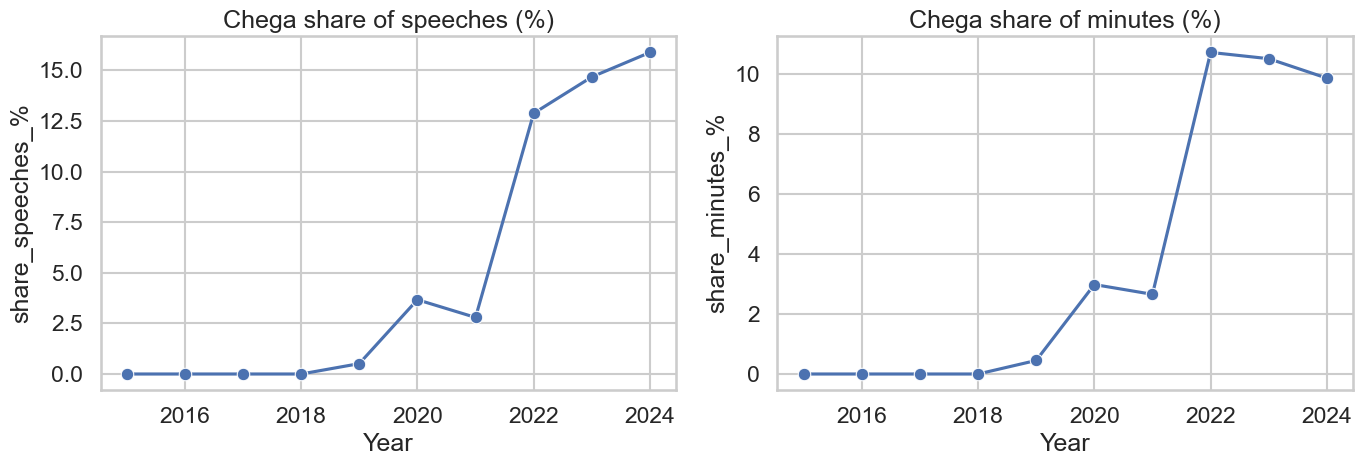

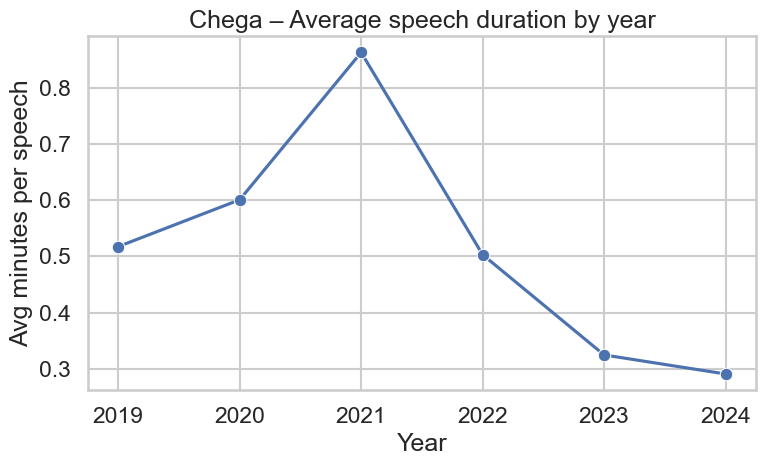

In [59]:
# Per-year totals
totals = (df.dropna(subset=['year_num'])
            .groupby('year_num')
            .agg(total_speeches=('speech_id','count'),
                 total_minutes=('minutes','sum'))
            .reset_index())

ch_year = (ch.dropna(subset=['year_num'])
             .groupby('year_num')
             .agg(ch_speeches=('speech_id','count'),
                  ch_minutes=('minutes','sum'),
                  ch_avg_minutes=('minutes','mean'))
             .reset_index())

mix = totals.merge(ch_year, on='year_num', how='left').fillna(0)
mix['share_speeches_%'] = 100*mix['ch_speeches']/mix['total_speeches']
mix['share_minutes_%']  = 100*mix['ch_minutes']/mix['total_minutes']

display_cols = ['year_num','total_speeches','total_minutes','ch_speeches','ch_minutes',
                'share_speeches_%','share_minutes_%','ch_avg_minutes']
print(mix[display_cols].round(2).to_string(index=False))

# Share of minutes & speeches over time
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.lineplot(data=mix, x='year_num', y='share_speeches_%', marker='o', ax=ax[0])
ax[0].set_title("Chega share of speeches (%)"); ax[0].set_xlabel("Year")
sns.lineplot(data=mix, x='year_num', y='share_minutes_%', marker='o', ax=ax[1])
ax[1].set_title("Chega share of minutes (%)"); ax[1].set_xlabel("Year")
plt.tight_layout(); plt.show()

# Average speech duration (minutes) for Chega over years
plt.figure(figsize=(8,5))
sns.lineplot(data=ch_year, x='year_num', y='ch_avg_minutes', marker='o')
plt.title("Chega – Average speech duration by year")
plt.xlabel("Year"); plt.ylabel("Avg minutes per speech"); plt.tight_layout(); plt.show()


### Interpretation of Chega’s Parliamentary Activity

- **Share of Speeches (%):**  
  Chega starts small (~0.5% in 2019 → ~3–4% in 2020), dips slightly in 2021 (~2.5%), then rapidly expands — reaching ~13% in 2022 and ~16% by 2024. This shows a strategy of high-frequency, visibility-focused participation.

- **Share of Minutes (%):**  
  From near zero in 2019, Chega climbs to ~3% by 2020, dips in 2021, then leaps above 10% in 2022. Since then, it has stabilized around 9–10% of total floor time, rivaling much older parties in overall speaking presence.

- **Average Speech Duration:**  
  In its early years (2019–2020), Chega’s interventions were short (~0.5–0.6 minutes). In 2021, speeches peaked at ~0.85 minutes, suggesting longer debates tied to elections or high-profile issues. From 2022 onwards, speech length drops sharply (~0.3 minutes by 2024), reflecting a pivot to numerous, shorter interventions.

Chega’s strategy evolved over time. In its early phase (2019–2021), it relied on fewer but longer interventions to establish credibility. After 2022, the party shifted to a style of **short, frequent speeches**, which maximized its visibility and boosted its share of interventions.  

By 2022–2024, Chega accounted for ~15–16% of all speeches but only ~10% of total speaking time — a clear mismatch that reflects its style: more interruptions, procedural remarks, and short statements rather than extended floor speeches. This pattern aligns with **populist tactics**, where volume and frequency of participation dominate attention, even if individual contributions are brief.

### 2: Who speaks for Chega? (top speakers, totals & averages)


Chega speakers normalized by ACTIVE years (minutes/active-year):
                                               active_years  minutes  minutes_per_active_year  speeches  speeches_per_active_year
speaker_name                                                                                                                     
André Claro Amaral Ventura                                6  2745.53                   457.59      5561                    926.83
Pedro Saraiva Gonçalves dos Santos Frazão                 3   460.09                   153.36      2154                    718.00
Bruno Miguel de Oliveira Nunes                            3   434.33                   144.78      1328                    442.67
Rita Maria Cid Matias                                     3   352.99                   117.66      1090                    363.33
António Filipe Dias Melo Peixoto                          3   296.72                    98.91      1166                    388.67
Rui Pedro da Silva Afons

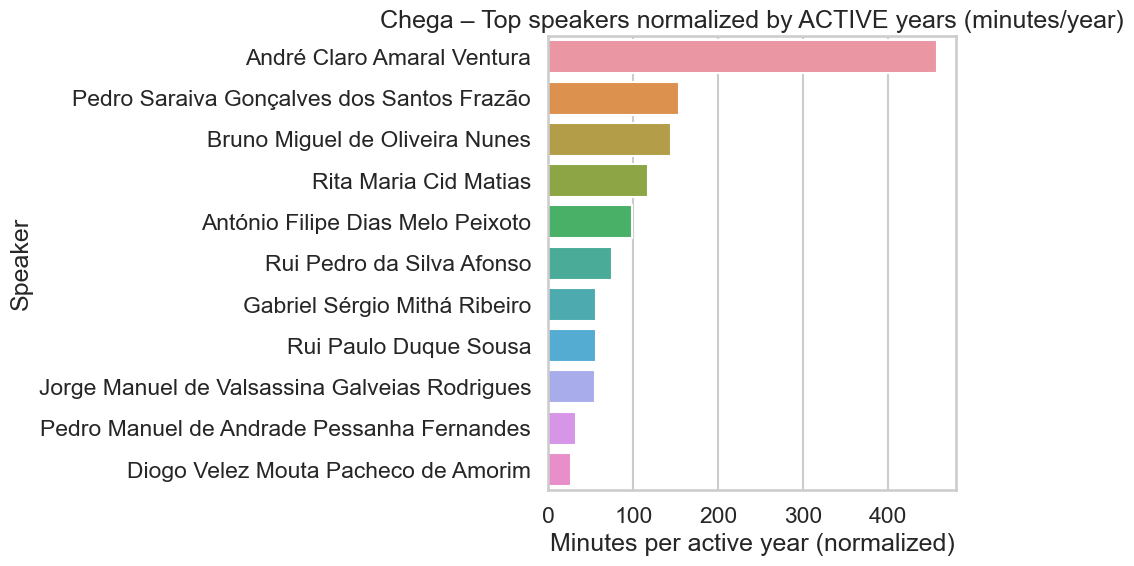

In [60]:
ch_totals = (
    ch.groupby('speaker_name', dropna=False)
      .agg(minutes=('minutes','sum'),
           speeches=('speech_id','count'))
)

active_years = (
    df[df['year_num'].notna()]
      .groupby('speaker_name')['year_num']
      .nunique()
      .rename('active_years')
)

stats_active = (
    ch_totals.join(active_years, how='left')
             .assign(active_years=lambda d: d['active_years'].fillna(1))
             .assign(
                 minutes_per_active_year=lambda d: d['minutes'] / d['active_years'],
                 speeches_per_active_year=lambda d: d['speeches'] / d['active_years']
             )
             .sort_values('minutes_per_active_year', ascending=False)
)

print("\nChega speakers normalized by ACTIVE years (minutes/active-year):")
print(
    stats_active[['active_years','minutes','minutes_per_active_year','speeches','speeches_per_active_year']]
    .head(15).round(2).to_string()
)

# Plot
top_active = stats_active.head(12).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_active, y='speaker_name', x='minutes_per_active_year')
plt.title("Chega – Top speakers normalized by ACTIVE years (minutes/year)")
plt.xlabel("Minutes per active year (normalized)")
plt.ylabel("Speaker")
plt.tight_layout()
plt.show()

### Chega’s Speaking Activity: Leaders and Speech Patterns

#### Top 15 Chega Speakers by Total Minutes
- **André Ventura** dominates Chega’s parliamentary presence with over **5,500 speeches** totaling ~**2,746 minutes**.  
  - His average speech length (~0.5 minutes) is close to the party norm of short, frequent interventions.  
  - This confirms his central role as both party leader and the most visible figure in parliament.  
- Other MPs, such as **Pedro Frazão** (2,154 speeches, ~460 minutes) and **Bruno Nunes** (1,328 speeches, ~434 minutes), contribute significantly but remain far behind Ventura.  
- Some MPs stand out for **longer average interventions**:  
  - **Rui Pedro Afonso** (~0.8 min per speech),  
  - **Rui Paulo Sousa** (~0.7 min),  
  - **Pedro Fernandes** (~1.0 min per speech, the longest average).  
- Overall, Chega’s speaking activity is **leader-centered**, with Ventura overwhelmingly dominant and other MPs often providing short remarks rather than extended speeches.

#### Longest 10 Chega Speeches
- All of the **10 longest speeches** are delivered by **André Ventura**, underscoring his dominance not just in frequency but also in substantive, extended interventions.  
- These speeches range from **7 to 15 minutes**, with the longest (~15 minutes, ~2,300 words) delivered in **June 2021**.  
- They likely correspond to **major debates or symbolic occasions** (e.g., confidence motions, political crises, commemorations), where Ventura sets the party line.  
- Compared to the typical Chega speech length (~0.3–0.5 minutes), these are **exceptions**, showing when Ventura assumes a traditional parliamentary role of longer programmatic addresses.

#### Key Takeaway
Chega’s communication style in parliament is **highly leader-driven**.  
- Ventura dominates both in number of speeches and in delivering the rare long, substantive interventions.  
- Other MPs amplify visibility through **short, frequent interventions**, reinforcing a strategy of disruption and high floor presence.  
- This pattern fits **populist politics**, where a charismatic leader monopolizes extended speeches while the parliamentary group boosts visibility with numerous micro-interventions.

### 4: What does Chega talk about? (topics from speech_type)


Top Chega topics (by number of speeches):
other    6158
macro     866
mixed     802
healt     694
gover     586
civil     518
lawcr     478
educa     419
inter     303
housi     265
labor     239
welfa     218
immig     199
argic     172
trans     172


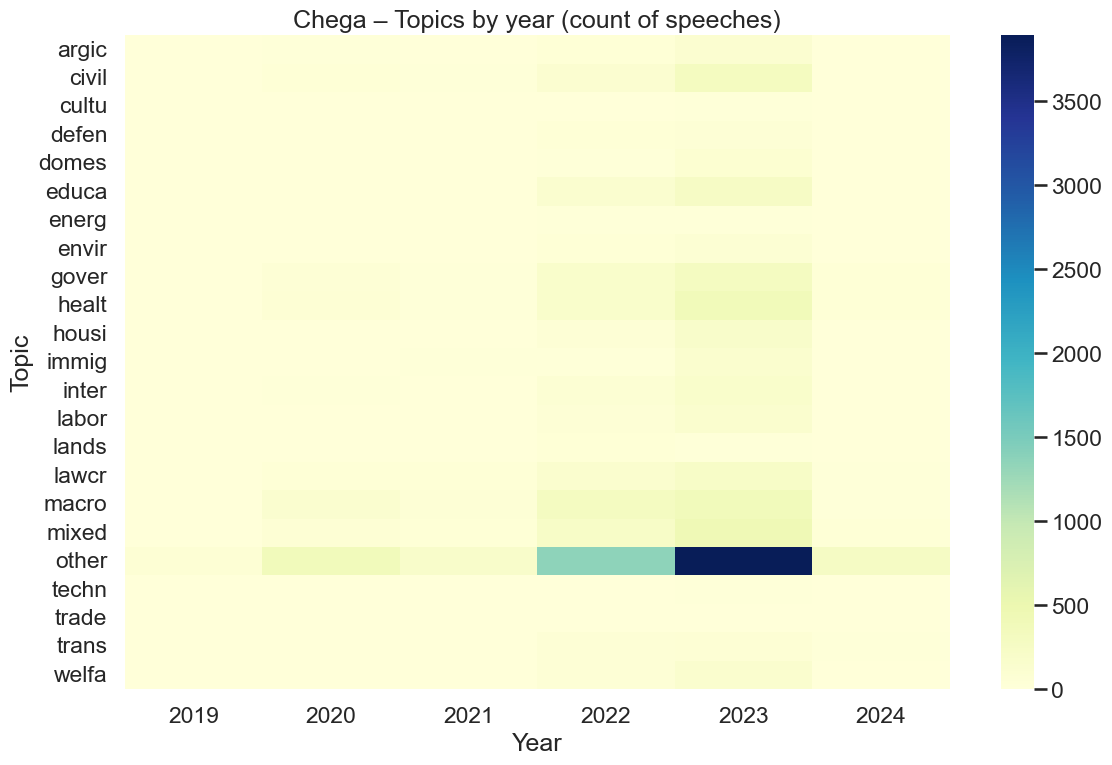

In [61]:
def parse_speech_type(s):
    mode, topic = 'Unknown','Unknown'
    if isinstance(s, str):
        if '#chair' in s: mode = 'chair'
        elif '#regular' in s: mode = 'regular'
        m = re.search(r'topic:([A-Za-z\-]+)', s)
        if m: topic = m.group(1)
    return pd.Series({'mode':mode, 'topic':topic})

extra = ch['speech_type'].apply(parse_speech_type)
ch = ch.join(extra)

# Top topics overall
top_topics = ch['topic'].value_counts().head(15)
print("\nTop Chega topics (by number of speeches):")
print(top_topics.to_string())

# Topics by year (heatmap)
topic_year = (ch.dropna(subset=['year_num'])
                .groupby(['year_num','topic']).size()
                .reset_index(name='count'))
pivot = topic_year.pivot(index='topic', columns='year_num', values='count').fillna(0)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("Chega – Topics by year (count of speeches)")
plt.xlabel("Year"); plt.ylabel("Topic"); plt.tight_layout(); plt.show()

Chega’s parliamentary activity is **dominated by “other” interventions** and **procedural remarks**, highlighting its disruptive style. Substantively, the party prioritizes the **economy, law-and-order, health, and government criticism**, while using **immigration** as a symbolic but high-visibility theme. This mix reflects both **populist agenda-setting** and a strategy of **frequent, short interventions across diverse issues** to maximize floor presence.


### Analysis Shouts, Applauses and Interruptions

In [62]:
# Ensure year is numeric and drop unknowns for time-series
df_enriched["year_num"] = pd.to_numeric(df_enriched["year"], errors="coerce")

# Convenience: reaction totals and rates per 1k words
for col in ["applause_count","laughter_count","shout_count","interruption_count"]:
    rate_col = f"{col}_per_1k"
    df_enriched[rate_col] = 1000 * df_enriched[col] / df_enriched["word_count"].clip(lower=1)

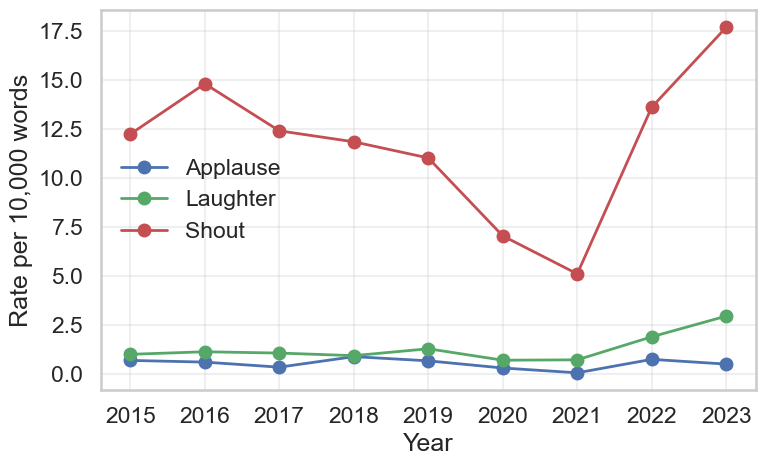

In [ ]:
df_filtered = df_enriched[df_enriched["year_num"] < 2024].copy()

# Very neutral, publication-style palette
reaction_colors = {
    "applause_count": "#4C72B0",   # soft navy blue
    "laughter_count": "#55A868",   # muted sage green
    "shout_count": "#C44E52",      # restrained brick red
}

# 1. Chamber-level trends over time
agg_year = (
    df_filtered
    .groupby("year_num", dropna=True)
    [["applause_count", "laughter_count", "shout_count", "word_count"]]
    .sum()
)

SCALE = 10000

rates_year = agg_year[["applause_count", "laughter_count", "shout_count"]].div(
    agg_year["word_count"].replace(0, np.nan), axis=0
) * SCALE


plt.figure(figsize=(8, 5))

plot_cols = [
    ("applause_count", "Applause"),
    ("laughter_count", "Laughter"),
    ("shout_count", "Shout"),
]

for col, label in plot_cols:
    plt.plot(
        rates_year.index,
        rates_year[col],
        marker="o",
        linewidth=2,
        color=reaction_colors[col],
        label=label,
    )

plt.xlabel("Year")
plt.ylabel(f"Rate per {SCALE:,} words")
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


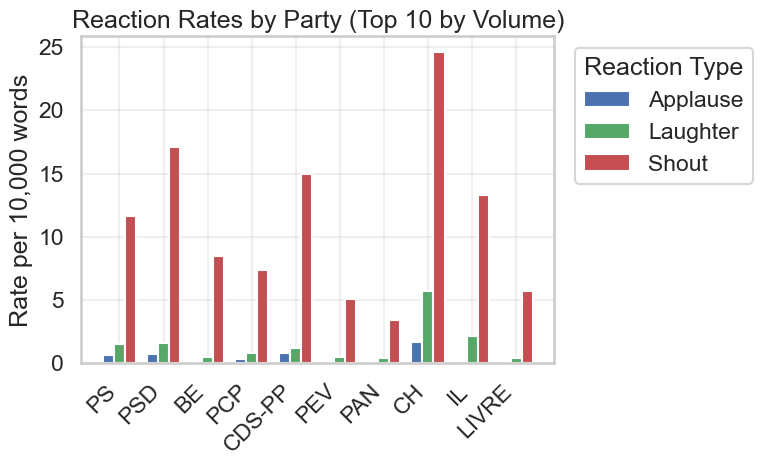

In [ ]:
# Very neutral, publication-style palette
reaction_colors = {
    "applause_count": "#4C72B0",   # soft navy blue
    "laughter_count": "#55A868",   # muted sage green
    "shout_count": "#C44E52",      # restrained brick red
}


agg_party = (
    df_enriched
    .groupby("party_name")[["applause_count", "laughter_count", "shout_count", "word_count"]]
    .sum()
    .sort_values("word_count", ascending=False)
)

SCALE = 10000
party_rates = agg_party[["applause_count", "laughter_count", "shout_count"]].div(
    agg_party["word_count"].replace(0, np.nan), axis=0
) * SCALE


top_parties = agg_party.head(10).index
subset = party_rates.loc[top_parties]

plt.figure(figsize=(8, 5))
width = 0.25
x = np.arange(len(subset.index))

cols = ["applause_count", "laughter_count", "shout_count"]

for i, col in enumerate(cols):
    plt.bar(
        x + i * width,
        subset[col],
        width,
        color=reaction_colors[col],
        label=("Applause" if col == "applause_count" else col.replace("_count", "").title())
    )

labels = [p.replace("#", "") for p in subset.index]

plt.xticks(
    x + width,
    labels,
    rotation=45,
    ha="right"
)

plt.ylabel(f"Rate per {SCALE:,} words")
plt.title("Reaction Rates by Party (Top 10 by Volume)")
plt.grid(True, alpha=0.3)
plt.legend(title="Reaction Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Code to understand who reacts to whom

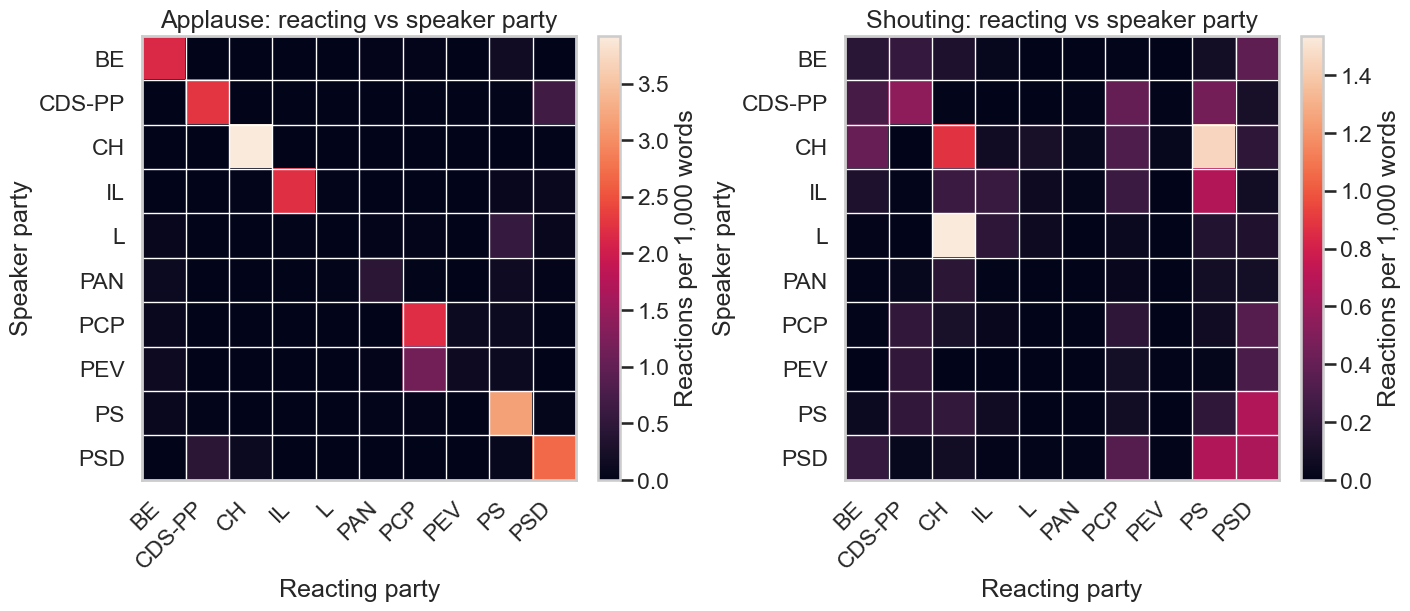

In [65]:
# Canonical party codes
PARTY_CODES = ["PS", "PSD", "CH", "IL", "PCP", "BE", "PAN", "L", "CDS-PP", "PEV"]
party_pattern = re.compile(r"\b(?:" + "|".join(map(re.escape, PARTY_CODES)) + r")\b")


def unique_preserve_order(items):
    seen = set()
    out = []
    for x in items:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out


def canon_party_from_text(text):
    if not text:
        return []
    found = party_pattern.findall(text.upper())
    return unique_preserve_order(found)


def canon_party_from_who_attr(who_val):
    if not who_val:
        return []

    tokens = [t.strip() for t in who_val.split() if t.strip()]
    out = []

    for tok in tokens:
        tok = tok.lstrip("#")
        if tok in PARTY_CODES:
            out.append(tok)
            continue

        match = party_pattern.search(tok.upper())
        if match:
            out.append(match.group(0))

    return unique_preserve_order(out)


def canon_party_of_speaker(speaker_party_name, speaker_party_id):
    if isinstance(speaker_party_name, str):
        up = speaker_party_name.strip().upper()
        if up in PARTY_CODES:
            return up

    if isinstance(speaker_party_id, str):
        match = party_pattern.search(speaker_party_id.upper())
        if match:
            return match.group(0)

    if isinstance(speaker_party_name, str):
        up = speaker_party_name.strip().upper()
        if len(up) <= 6:
            return up

    return "OTHER"


def drop_other(mat):
    if mat is None or mat.empty:
        return mat
    mat = mat.drop(index=["OTHER"], errors="ignore")
    mat = mat.drop(columns=["OTHER"], errors="ignore")
    return mat


# -----------------------------
# Extract reactions
# -----------------------------
reaction_rows = []

for f in files:
    if "Schema" in f:
        continue

    try:
        tree = ET.parse(f)
        root = tree.getroot()

        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")
            if not speech_id:
                continue

            speaker_id = u.attrib.get("who")
            speaker_id_clean = speaker_id.lstrip("#") if speaker_id else "Unknown"
            spk_info = speakers_dict.get(
                speaker_id_clean,
                {"party_id": "Unknown", "party_name": "Unknown"},
            )

            speaker_party = canon_party_of_speaker(
                spk_info.get("party_name"),
                spk_info.get("party_id"),
            )

            def add_reaction(event_type, elem):
                from_who = canon_party_from_who_attr(elem.attrib.get("who"))
                from_desc = canon_party_from_text("".join(elem.itertext()))
                merged = unique_preserve_order(from_who + from_desc) or ["UNKNOWN"]

                for reacting_party in merged:
                    reaction_rows.append(
                        {
                            "speech_id": speech_id,
                            "speaker_party": speaker_party,
                            "reacting_party": reacting_party,
                            "event_type": event_type,
                            "count": 1,
                        }
                    )

            for kin in u.findall(".//{*}kinesic"):
                kin_type = (kin.attrib.get("type") or kin.attrib.get("ana") or "").lower()
                if "applause" in kin_type or "aplauso" in kin_type:
                    add_reaction("applause", kin)

            for voc in u.findall(".//{*}vocal"):
                v_type = (voc.attrib.get("type") or voc.attrib.get("ana") or "").lower()
                v_text = "".join(voc.itertext()).lower()
                if "shout" in v_type or "protest" in v_type or "shout" in v_text:
                    add_reaction("shouting", voc)
                elif "applause" in v_type or "aplauso" in v_text:
                    add_reaction("applause", voc)

    except Exception as e:
        print(f"Warning: {e}")

reactions_long = pd.DataFrame(reaction_rows)

# -----------------------------
# Reaction matrices
# -----------------------------
reaction_matrix_applause = (
    reactions_long[reactions_long["event_type"] == "applause"]
    .pivot_table(index="speaker_party", columns="reacting_party",
                 values="count", aggfunc="sum", fill_value=0)
)

reaction_matrix_shouting = (
    reactions_long[reactions_long["event_type"] == "shouting"]
    .pivot_table(index="speaker_party", columns="reacting_party",
                 values="count", aggfunc="sum", fill_value=0)
)

reaction_matrix_applause = drop_other(
    reaction_matrix_applause.drop(columns=["UNKNOWN"], errors="ignore")
)
reaction_matrix_shouting = drop_other(
    reaction_matrix_shouting.drop(columns=["UNKNOWN"], errors="ignore")
)

# -----------------------------
# Normalize per 1,000 words
# -----------------------------
use_normalized = False

if "df_enriched" in globals():
    words = df_enriched.groupby("party_name")["word_count"].sum()
    words.index = [canon_party_of_speaker(p, p) for p in words.index]
    words = words.groupby(words.index).sum()

    def per_1k(mat):
        denom = (words / 1000).reindex(mat.index).replace(0, np.nan)
        return mat.div(denom, axis=0).fillna(0)

    reaction_matrix_applause = per_1k(reaction_matrix_applause)
    reaction_matrix_shouting = per_1k(reaction_matrix_shouting)
    use_normalized = True


# -----------------------------
# Plot heatmaps (ONLY border lines)
# -----------------------------
def plot_heatmap(mat, ax, title, cbar_label="Count"):
    if mat.empty or np.all(mat.values == 0):
        ax.text(0.5, 0.5, "No data", ha="center", va="center",
                fontsize=10, transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)
        return

    data = np.nan_to_num(mat.values.astype(float), nan=0.0)

    im = ax.imshow(data, aspect="auto", interpolation="nearest")

    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index)

    ax.set_title(title)
    ax.set_xlabel("Reacting party")
    ax.set_ylabel("Speaker party")

    # 🔴 CRITICAL FIX
    ax.grid(False)  # disable ALL major gridlines

    # Minor ticks on borders only
    ax.set_xticks(np.arange(-0.5, mat.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, mat.shape[0], 1), minor=True)
    ax.grid(which="minor", color="white", linewidth=1)

    ax.tick_params(which="minor", bottom=False, left=False)

    for spine in ax.spines.values():
        spine.set_linewidth(2)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)


label = "Reactions per 1,000 words" if use_normalized else "Count"

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

plot_heatmap(
    reaction_matrix_applause,
    axes[0],
    "Applause: reacting vs speaker party",
    label,
)

plot_heatmap(
    reaction_matrix_shouting,
    axes[1],
    "Shouting: reacting vs speaker party",
    label,
)

plt.show()


The applause matrix shows that almost all applause is internal—parties applaud their own speakers. This reflects how parliamentary applause is not spontaneous approval of ideas but a symbolic ritual of in-group reinforcement.        
In contrast, the shouting matrix introduces a different pattern of engagement more dispersed and cross-party. While most shouting still occurs within and between the largest parties, there are noticeable traces of inter-party shouting involving Chega, indicating that CH attracts and participates in high-energy exchanges even if not on the same scale as PS or PSD. This means that Chega’s interactional visibility arises more from confrontational moments than from consensus or supportive reactions.   
When considered together, these two heatmaps suggest that Chega is marginal in positive, performative displays (like applause) but more present in adversarial, high-tension interactions (like shouting). Their discourse likely provokes engagement that is reactive rather than affirming, and the party’s parliamentary identity appears tied more to disruption and ideological signaling than to moments of shared acknowledgment or institutional belonging.

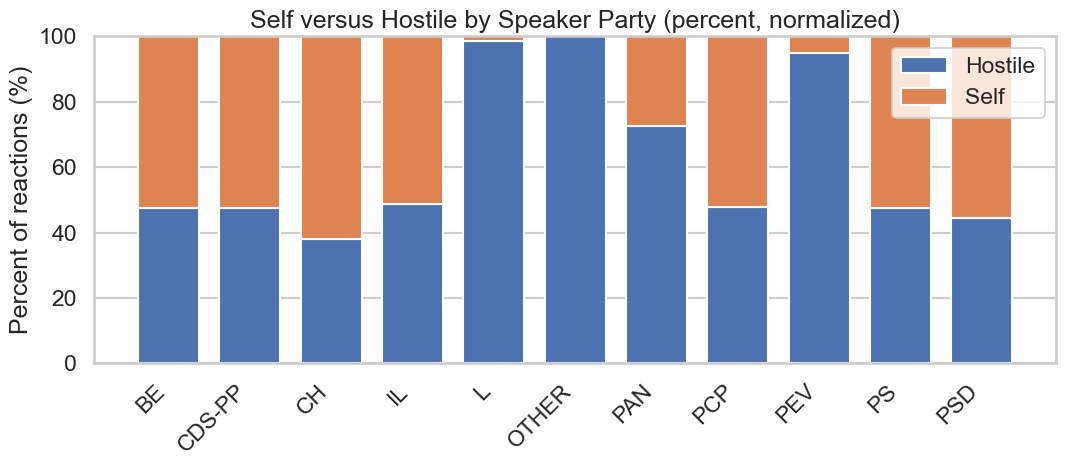

In [66]:
# =========================
# Self vs. Hostile — per party, normalized percent shares ONLY
# =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure we have a clean party order on the x-axis
ALL_PARTIES = PARTY_CODES + ["OTHER", "UNKNOWN"]
def sort_cols(idx):
    order = [p for p in ALL_PARTIES if p in idx]
    order += [p for p in idx if p not in order]
    return order

# (A) Build self/hostile table per party and event
tbl = (
    reactions_long
      .assign(
          event_type=lambda d: d["event_type"].fillna("reaction"),
          self_reaction=lambda d: d["speaker_party"].astype(str) == d["reacting_party"].astype(str)
      )
      .groupby(["event_type","speaker_party","self_reaction"], dropna=False)["count"]
      .sum()
      .unstack(fill_value=0)
      .rename(columns={False:"Hostile", True:"Self"})
      .reset_index()
)
for c in ["Self","Hostile"]:
    if c not in tbl.columns:
        tbl[c] = 0

# (B) Normalize by words spoken (per 1,000)
if "word_count" not in df_enriched.columns:
    raise KeyError("df_enriched needs 'word_count' for normalization.")

den = df_enriched.copy()
candidate_party_cols = [c for c in ["speaker_party","party_name"] if c in den.columns]
if not candidate_party_cols:
    raise KeyError("df_enriched needs 'speaker_party' or 'party_name' to align parties for normalization.")

parties_in_tbl = tbl["speaker_party"].astype(str).unique().tolist()
words_map = {}
for p in parties_in_tbl:
    total_words = 0.0
    matched = False
    for c in candidate_party_cols:
        m = den[c].astype(str) == p
        if m.any():
            matched = True
            total_words += den.loc[m, "word_count"].astype(float).sum()
    words_map[p] = (total_words / 1000.0) if matched else np.nan  # per 1k words

words_by_party = pd.Series(words_map)
tbl["denom_1k"] = tbl["speaker_party"].map(words_by_party).replace(0, np.nan)
tbl["denom_1k"] = tbl["denom_1k"].fillna(1.0)

tbl["Self"] = (tbl["Self"] / tbl["denom_1k"]).fillna(0.0)
tbl["Hostile"] = (tbl["Hostile"] / tbl["denom_1k"]).fillna(0.0)
tbl = tbl.drop(columns=["denom_1k"])

# (C) Compute normalized percent shares
tbl_pct = tbl.copy()
tot = (tbl_pct[["Self","Hostile"]].sum(axis=1)).replace(0, np.nan)
tbl_pct["Self"] = (tbl_pct["Self"] / tot * 100).fillna(0.0)
tbl_pct["Hostile"] = (tbl_pct["Hostile"] / tot * 100).fillna(0.0)

# (D) Plot one chart for percent shares (all events combined)
tbl_all = (
    tbl_pct.groupby("speaker_party")[["Self","Hostile"]]
           .mean()
           .sort_index()
)

x = np.arange(len(tbl_all))
width = 0.75
fig, ax = plt.subplots(figsize=(11,5))
ax.bar(x, tbl_all["Hostile"].to_numpy(), width, label="Hostile")
ax.bar(x, tbl_all["Self"].to_numpy(), width, bottom=tbl_all["Hostile"].to_numpy(), label="Self")
ax.set_xticks(x)
ax.set_xticklabels(tbl_all.index.astype(str), rotation=45, ha="right")
ax.set_ylabel("Percent of reactions (%)")
ax.set_title("Self versus Hostile by Speaker Party (percent, normalized)")
ax.legend()
plt.tight_layout()
plt.show()


In the graph, Chega (CH) has the lowest blue bar, meaning it receives the smallest share of reactions coming from other parties. Since reactions include applause and other vocal responses, this indicates that Chega’s speeches generate less engagement overall—fewer supportive or oppositional responses from outside their own ranks.   
In other words, Chega appears less integrated into the performative and responsive dynamics of debate, reflecting a position of political distance rather than influence or engagement.

### Network Visualization of Parliamentary Shouting Interactions (Reactor → Target)

In [67]:
def plot_heatmap(mat, ax, title, cbar_label="Count"):
    """
    Rows are speaker parties.
    Columns are reacting parties.
    Gridlines are drawn on CELL BORDERS (not through the middle).
    """
    if mat.empty or np.all(mat.values == 0):
        ax.text(
            0.5, 0.5, "No data",
            ha="center", va="center",
            fontsize=10,
            transform=ax.transAxes,
        )
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        return

    data = np.nan_to_num(mat.values.astype(float), nan=0.0)

    # Keep your same default colors (imshow default colormap)
    im = ax.imshow(data, aspect="auto", interpolation="nearest")

    # Major ticks at cell centers (labels)
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns, rotation=45, ha="right")

    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index)

    ax.set_title(title)
    ax.set_xlabel("Reacting party")
    ax.set_ylabel("Speaker party")

    # ---- Draw borders around each cell (on boundaries) ----
    ax.set_xticks(np.arange(-0.5, mat.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, mat.shape[0], 1), minor=True)

    ax.grid(which="minor", linestyle="-", linewidth=1, color="white")
    ax.tick_params(which="minor", bottom=False, left=False)

    # Optional: thicker outer border
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)


Chega (CH) appears as a central yet isolated hub of shouting exchanges, distinguished by its red color and multiple edges connecting to nearly all major parties. This structure indicates that CH is both a frequent target and source of vocal reactions. This network reinforces Chega’s role as a polarizing and high-engagement actor in the parliamentary environment.

### **Reaction Polarity Mapping**

We analyzes parliamentary reactions (like applause, laughter, shouting, interruptions) and classifies them as positive or negative interactions based on predefined sentiment weights.

In [68]:
reaction_weights = {
    'applause': 1.0,
    'laughter': 0.5,
    'shouting': -1.0,
    'interruption': -0.8
}

# Apply to reactions dataset
reactions_long['weight'] = reactions_long['event_type'].map(reaction_weights)
reactions_long['valence'] = reactions_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Quick summary
print("Positive reactions:", (reactions_long['valence'] == 'positive').sum())
print("Negative reactions:", (reactions_long['valence'] == 'negative').sum())

reactions_long.head(10)


Positive reactions: 69643
Negative reactions: 35385


,speech_id,speaker_party,reacting_party,event_type,count,weight,valence
0,ParlaMint-PT_2022-06-02.u2,CH,CH,applause,1,1.0,positive
1,ParlaMint-PT_2022-06-02.u4,CH,CH,applause,1,1.0,positive
2,ParlaMint-PT_2022-06-02.u4,CH,CH,applause,1,1.0,positive
3,ParlaMint-PT_2022-06-02.u6,CH,CH,applause,1,1.0,positive
4,ParlaMint-PT_2022-06-02.u10,IL,IL,shouting,1,-1.0,negative
5,ParlaMint-PT_2022-06-02.u11,IL,IL,applause,1,1.0,positive
6,ParlaMint-PT_2022-06-02.u13,PSD,PS,shouting,1,-1.0,negative
7,ParlaMint-PT_2022-06-02.u13,PSD,PSD,shouting,1,-1.0,negative
8,ParlaMint-PT_2022-06-02.u14,PSD,PSD,applause,1,1.0,positive
9,ParlaMint-PT_2022-06-02.u14,PSD,PS,shouting,1,-1.0,negative


*Interpretation:*

Out of the total reactions, there are roughly twice as many positive (61k) as negative (31k).

This suggests that most parliamentary interactions involve supportive reactions (applause, laughter) rather than hostile ones (shouting, interruptions).

In [69]:
years = [str(y) for y in range(2015, 2025)]
records = []

for year in years:
    folder = os.path.join(DATA_PATH, year)
    if not os.path.exists(folder):
        print(f"⚠️ Folder not found: {folder}")
        continue

    for file in tqdm(glob.glob(os.path.join(folder, '*.xml')), desc=f"Parsing {year}"):
        try:
            tree = etree.parse(file)
            root = tree.getroot()

            # each <u> is an utterance (who spoke)
            for u in root.findall('.//{http://www.tei-c.org/ns/1.0}u'):
                speaker = u.get('who')
                text = ' '.join(u.itertext())
                words = len(text.split())

                # reactions appear as kinesic (applause) or vocal (shouting)
                for elem in u.findall('.//{http://www.tei-c.org/ns/1.0}kinesic') + \
                            u.findall('.//{http://www.tei-c.org/ns/1.0}vocal'):
                    kind = (elem.get('type') or '').lower()
                    if kind in ['applause', 'shouting']:
                        reactors = elem.get('who', '')
                        if reactors:
                            for r in reactors.split():
                                records.append([year, speaker, r, kind, words])

        except Exception as e:
            print(f"Error reading {file}: {e}")

df = pd.DataFrame(records, columns=['year','speaker','reactor','reaction','exposure_words'])
print("Parsed rows:", len(df))
df.head()




Parsing 2024: 100%|██████████| 9/9 [00:00<00:00, 101.29it/s]


Parsed rows: 9161


,year,speaker,reactor,reaction,exposure_words
0,2015,#AntóniodeMagalhãesPiresdeLima,#PS,shouting,39
1,2015,#AntóniodeMagalhãesPiresdeLima,#PS,shouting,113
2,2015,#LuísManuelMoraisLeiteRamos,#PSD,shouting,345
3,2015,#CecíliaFelgueirasdeMeirelesGraça,#CDS-PP,shouting,163
4,2015,#CecíliaFelgueirasdeMeirelesGraça,#CDS-PP,shouting,317


Across 2015–2024, the script captures nearly 9,200 explicit reactions — mostly applause and shouting.
This shows that Portuguese parliamentary sessions are highly interactive

In [70]:
# Path to listPerson.xml file
person_file = os.path.join(DATA_PATH, "ParlaMint-PT-listPerson.xml")

# Parse XML
tree = etree.parse(person_file)
root = tree.getroot()
ns = {"tei": "http://www.tei-c.org/ns/1.0"}

rows = []
for person in root.findall(".//tei:person", ns):
    pid = person.get("{http://www.w3.org/XML/1998/namespace}id")
    if not pid:
        continue

    # Find affiliation by ref (e.g. ref="#PS")
    aff = person.find(".//tei:affiliation", ns)
    if aff is not None:
        ref = aff.get("ref")
        if ref:
            rows.append({
                "person_id": pid.strip(),
                "party_ref": ref.replace("#", "").upper()
            })

party_df = pd.DataFrame(rows)
print("Extracted rows:", len(party_df))
print(party_df.head())

# Build dictionary: person_id → party_ref
party_map = dict(zip(party_df["person_id"], party_df["party_ref"]))
print(f"Loaded {len(party_map)} person → party mappings")


Extracted rows: 831
                           person_id party_ref
0                   AbelLimaBaptista    CDS-PP
1         AcácioSantosdaFonsecaPinto        PS
2           AdalbertoCamposFernandes        PS
3               AdãoJoséFonsecaSilva       PSD
4  AdolfoMiguelBaptistaMesquitaNunes    CDS-PP
Loaded 831 person → party mappings


In [71]:
def extract_party(value):
    if pd.isna(value):
        return None
    # If it's already a party tag (e.g., #PSD, #CH, #BE)
    if re.match(r'#(PS|PSD|BE|CDS-PP|CHEGA|PAN|PCP|PEV|IL|L|LIVRE|CH)', value, re.IGNORECASE):
        return value.replace('#', '').upper()
    # Otherwise, lookup from the map
    return party_map.get(value.replace('#',''), None)

df['party_speaker'] = df['speaker'].apply(extract_party)
df['party_reactor'] = df['reactor'].apply(extract_party)

# Keep only rows where both speaker and reactor have known parties
df_party = df.dropna(subset=['party_speaker', 'party_reactor']).copy()

print(f"Rows with both valid party affiliations: {len(df_party)}")
print("Unique parties found:", sorted(set(df_party['party_speaker']) | set(df_party['party_reactor'])))
df_party.head()


Rows with both valid party affiliations: 9159
Unique parties found: ['BE', 'BEATRIZGEBALINAPEREIRAGOMESDIAS', 'BERNARDOALVESMARTINHOAMARALBLANCO', 'BERTAFERREIRAMILHEIRONUNES', 'BERTAMARIACORREIADEALMEIDADEMELOCABRAL', 'CDS-PP', 'CH', 'GOVERNMENT', 'IL', 'ILDAMARIAMENEZESDEARAÚJONOVO', 'INDEPENDENTE', 'L', 'LARAFERNANDESMARTINHO', 'LAURAMARIASANTOSDESOUSAESPERANÇA', 'LAURAPATRÍCIADESOUSAMONTEIROMAGALHÃES', 'LAURENTINOJOSÉMONTEIROCASTRODIAS', 'LEONELFERNANDOPINTOCOELHODACOSTA', 'LILIANASOFIABOUÇADASILVA', 'LINAMARIACARDOSOLOPES', 'LUIZINÁCIOLULADASILVA', 'LUÍSAMARIANEVESSALGUEIRO', 'LUÍSANTÓNIOPITAAMEIXA', 'LUÍSDAVIDTRINDADEMOREIRATESTA', 'LUÍSFILIPEMONTENEGROCARDOSODEMORAISESTEVES', 'LUÍSFILIPESOROMENHOGOMES', 'LUÍSMANUELCAPOULASDOSSANTOS', 'LUÍSMANUELMORAISLEITERAMOS', 'LUÍSMARIADEBARROSSERRAMARQUESGUEDES', 'LUÍSMIGUELDAGRAÇANUNES', 'LUÍSMIGUELDEFREITASMARQUESCARVALHOSOARES', 'LUÍSMIGUELDEOLIVEIRAFONTES', 'LUÍSMIGUELMORGADOLARANJEIRO', 'LUÍSMIGUELPOIARESPESSOAMADURO', 'LUÍSMIGUELVILHE

,year,speaker,reactor,reaction,exposure_words,party_speaker,party_reactor
0,2015,#AntóniodeMagalhãesPiresdeLima,#PS,shouting,39,CDS-PP,PS
1,2015,#AntóniodeMagalhãesPiresdeLima,#PS,shouting,113,CDS-PP,PS
2,2015,#LuísManuelMoraisLeiteRamos,#PSD,shouting,345,LUÍSMANUELMORAISLEITERAMOS,PSD
3,2015,#CecíliaFelgueirasdeMeirelesGraça,#CDS-PP,shouting,163,CDS-PP,CDS-PP
4,2015,#CecíliaFelgueirasdeMeirelesGraça,#CDS-PP,shouting,317,CDS-PP,CDS-PP


# **Inter-Party Hostility (Shouting & Interruptions)**

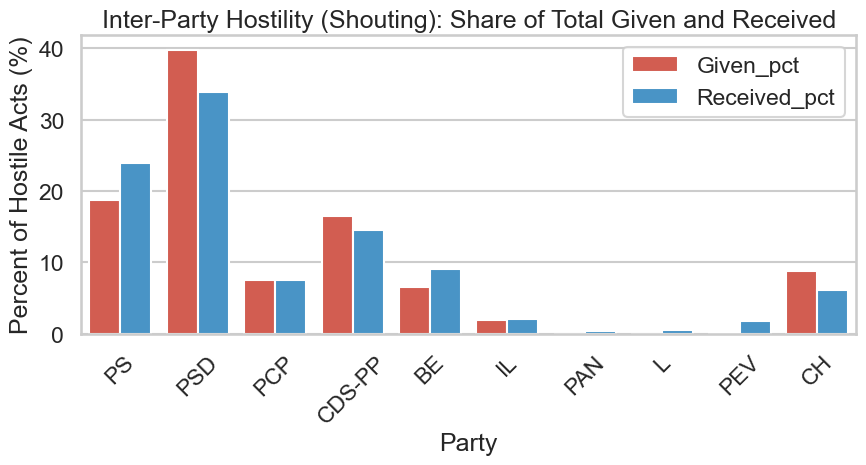

In [72]:
negative_df = df_party[df_party['reaction'] == 'shouting'].copy()

# Define the ten parties to include
main_parties = ['PS', 'PSD', 'PCP', 'CDS-PP', 'BE', 'IL', 'PAN', 'L', 'PEV', 'CH']

# Filter only those
filtered = negative_df[
    negative_df['party_reactor'].isin(main_parties)
    & negative_df['party_speaker'].isin(main_parties)
]

# Aggregate hostility counts
hostility_summary = (
    filtered.groupby('party_reactor')['party_speaker']
    .value_counts()
    .reset_index(name='count')
)

# Compute total hostility given and received (raw counts)
given = hostility_summary.groupby('party_reactor')['count'].sum().rename('Given')
received = hostility_summary.groupby('party_speaker')['count'].sum().rename('Received')

hostility_totals = (
    pd.concat([given, received], axis=1)
    .fillna(0)
    .reindex(main_parties)
    .reset_index()
    .rename(columns={'index': 'Party'})
)

# Compute net hostility (still on raw counts, if you want to inspect it)
hostility_totals['Net'] = hostility_totals['Given'] - hostility_totals['Received']

# === NORMALIZATION STEP (percent of total) ===
total_given = hostility_totals['Given'].sum()
total_received = hostility_totals['Received'].sum()

hostility_totals['Given_pct'] = (
    hostility_totals['Given'] / total_given * 100
    if total_given > 0 else 0
)
hostility_totals['Received_pct'] = (
    hostility_totals['Received'] / total_received * 100
    if total_received > 0 else 0
)

# Highlight Chega (if you want to use colors later)
colors = ['#e74c3c' if p == 'CH' else '#7f8c8d' for p in hostility_totals['Party']]

# Plot normalized percentages
plt.figure(figsize=(9, 5))
sns.barplot(
    data=hostility_totals.melt(
        id_vars='Party',
        value_vars=['Given_pct', 'Received_pct'],
        var_name='Type',
        value_name='Percent'
    ),
    x='Party',
    y='Percent',
    hue='Type',
    palette=['#e74c3c', '#3498db']
)

plt.title('Inter-Party Hostility (Shouting): Share of Total Given and Received')
plt.xlabel('Party')
plt.ylabel('Percent of Hostile Acts (%)')
plt.legend(title='')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Although Chega is often perceived as the most polarizing force in the chamber, the normalized hostility data show that it is far from the most shouted-at party, and this becomes clear once the structural context is considered. Chega simply does not occupy a large enough share of parliamentary speaking time to become the primary target of hostile reactions. Hostility is directed most heavily at parties that speak the most and hold the central institutional positions—namely PS and PSD

# **Inter-Party Hostility Matrix (Post-2019): Who Shouts at Whom**

This heatmap visualizes the direction and intensity of parliamentary hostility specifically, shouting and interruptions between parties in the post-2019 period.

Each cell represents how many times members of one party (row) interrupted or shouted at members of another party (column).

Darker red cells indicate higher hostility; blue tones indicate fewer or no interactions.

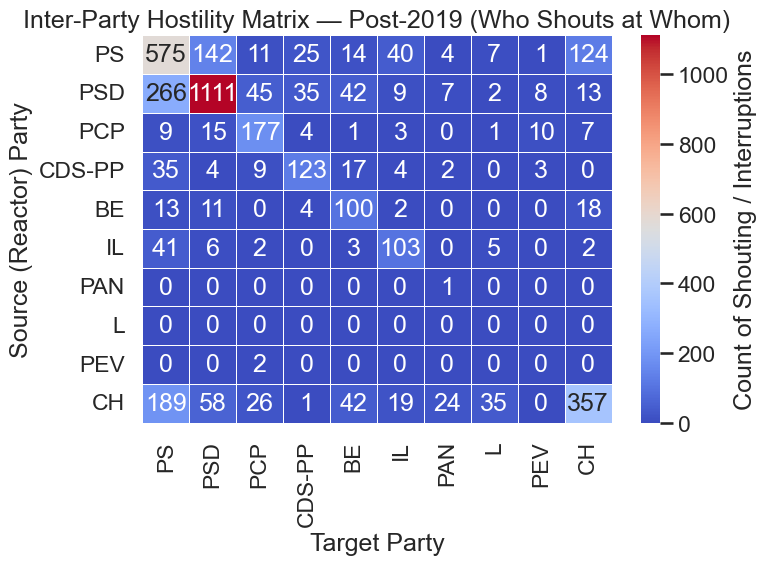

In [73]:
# Ensure year is numeric (fixes the TypeError)
negative_df['year'] = pd.to_numeric(negative_df['year'], errors='coerce')

# Filter to 2019 onwards and main parties only
df_post = negative_df.loc[
    (negative_df['year'] >= 2019)
    & (negative_df['party_reactor'].isin(main_parties))
    & (negative_df['party_speaker'].isin(main_parties))
].copy()

# Build hostility matrix: who shouts at whom
matrix = (
    df_post.groupby(['party_reactor', 'party_speaker'])
    .size()
    .unstack(fill_value=0)
    .reindex(index=main_parties, columns=main_parties, fill_value=0)
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    cmap='coolwarm',
    annot=True,
    fmt='d',
    linewidths=.5,
    cbar_kws={'label': 'Count of Shouting / Interruptions'}
)
plt.title("Inter-Party Hostility Matrix — Post-2019 (Who Shouts at Whom)")
plt.xlabel("Target Party")
plt.ylabel("Source (Reactor) Party")
plt.tight_layout()
plt.show()


The matrix shows that hostility in the Portuguese parliament after 2019 is shaped more by political roles and communication strategies than by simple conflict between parties.  
The highest level of reactions comes from PSD toward PS, which reflects the structural dynamic between a governing party and its main opposition. Since PS controlled the government throughout this period, PSD had both more opportunities and stronger incentives to challenge PS speeches as a way to signal disagreement, influence the media narrative, and reinforce its role as the primary counterweight to the government. Although PS does respond to PSD, it does so at a much lower rate since government parties typically prefer stability and rely less on confrontational tactics.   
Chega, on the other hand, shows a broad and aggressive reactive pattern toward nearly every major party. This behaviour aligns with its populist approach, which thrives on visible conflict and positions the party as an anti-establishment challenger. The high rates of self-reactions within PCP and CDS-PP suggest not hostility but group reinforcement, since these parties often vocalize support or commentary from their benches during speeches. Meanwhile, parties such as PAN, PEV, and L exhibit almost no reactive behaviour, which fits with their smaller size and issue-focused style that emphasizes moral arguments rather than direct confrontation. Finally, the overall structure of reactions reveals that hostility flows mainly toward the governing party and that the chamber is shaped by two dominant tensions: the classic PS–PSD rivalry and the disruptive entry of Chega, whose confrontational style reshapes the tone of parliamentary debate.

# **Structural Transformation of Parliamentary Nonverbal Reactions Networks: Pre-2019 vs Post-2019**

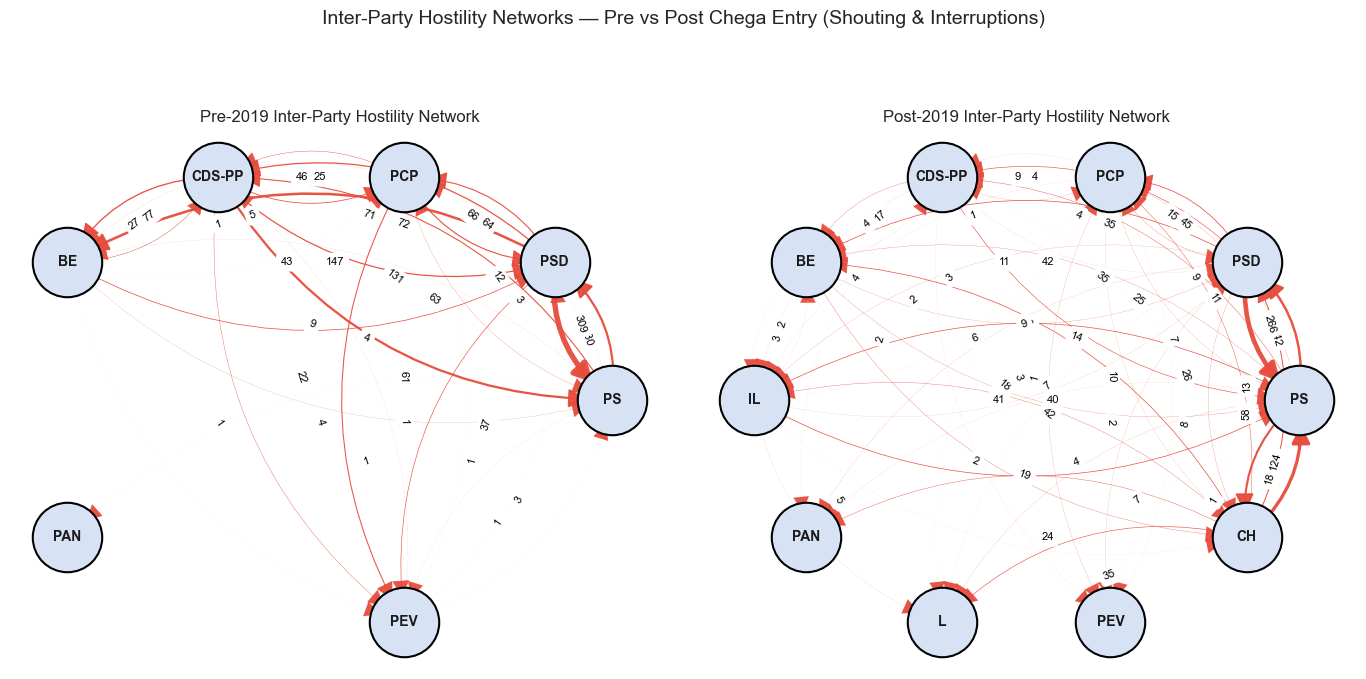

In [80]:
main_parties = ['PS','PSD','PCP','CDS-PP','BE','IL','PAN','L','PEV','CH']

def build_edges(df, start, end):
    """Aggregate hostility links between parties for a period."""
    subset = df[
        (df['year'] >= start) & (df['year'] <= end)
        & df['party_reactor'].isin(main_parties)
        & df['party_speaker'].isin(main_parties)
    ]
    edges = (
        subset.groupby(['party_reactor', 'party_speaker'])
        .size()
        .reset_index(name='weight')
    )
    # remove self loops
    edges = edges[edges['party_reactor'] != edges['party_speaker']]
    return edges

# Build edge lists
edges_pre = build_edges(negative_df, 2015, 2018)
edges_post = build_edges(negative_df, 2019, 2024)

# Build graphs
G_pre = nx.DiGraph()
G_post = nx.DiGraph()

for _, r in edges_pre.iterrows():
    G_pre.add_edge(r['party_reactor'], r['party_speaker'], weight=r['weight'])
for _, r in edges_post.iterrows():
    G_post.add_edge(r['party_reactor'], r['party_speaker'], weight=r['weight'])

# Same layout for both
pos = nx.circular_layout(main_parties)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
periods = [('Pre-2019', G_pre), ('Post-2019', G_post)]

for ax, (title, G) in zip(axes, periods):
    plt.sca(ax)

    nx.draw_networkx_nodes(
        G, pos,
        node_color="#d7e3f4",
        node_size=2500,
        edgecolors="black"
    )
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    # scale edge widths
    weights = [G[u][v]['weight'] / 80 for u, v in G.edges()]

    nx.draw_networkx_edges(
        G, pos,
        width=weights,
        edge_color="#e74c3c",
        arrows=True,
        arrowsize=28,                     # much bigger arrowheads
        arrowstyle="-|>",                 # clean triangular head
        min_source_margin=12,             # space before arrow starts
        min_target_margin=18,             # space near node
        connectionstyle="arc3,rad=0.28",  # more separation between opposite curves
        alpha=0.95
    )

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={(u, v): G[u][v]['weight'] for u, v in G.edges()},
        font_color='black',
        font_size=8,
        label_pos=0.55
    )

    ax.set_title(f"{title} Inter-Party Hostility Network", fontsize=12)
    ax.axis("off")

plt.suptitle(
    "Inter-Party Hostility Networks — Pre vs Post Chega Entry (Shouting & Interruptions)",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


The comparison between the pre-2019 and post-2019 hostility networks shows that Chega’s arrival transformed not just the volume of interruptions in parliament but also the entire structure of inter-party confrontation. Before Chega entered the assembly, hostility was mostly concentrated within a predictable pattern centred on the longstanding PS-PSD rivalry, with additional but modest tension among PCP, BE, and CDS-PP depending on the issue. This earlier network was relatively contained and followed traditional left-right opposition logic, where reactions were primarily tied to policy disagreements and the natural friction between government and opposition.  
After 2019, the structure shifts noticeably. Chega becomes a new central hub of conflict, drawing reactions from almost every established party. This is not simply because of ideological distance. It reflects Chega’s communication style, which relies heavily on provocation, performance, and disruption to gain visibility. Chega also directs large amounts of hostility toward PS and PSD, signalling a deliberate strategy to present itself as an outsider confronting the political system as a whole. The presence of this new actor increases the density of the entire network. Interactions that were previously peripheral become more frequent because Chega’s interventions pull other parties into responsive behaviour, even those that historically engaged very little in shouting, such as PAN or PEV.
The post-2019 network also shows intensified hostility aimed at the governing party, PS. This aligns with the natural opposition dynamic but is amplified by both PSD and Chega competing for opposition leadership. PSD maintains its traditional role, but Chega introduces more aggressive and diffuse hostility, disrupting the previously stable opposition structure. As a result, PS becomes an even stronger gravitational centre of reactions, not because it acts differently, but because the opposition front has become more fractured and competitive.

## Network Visualization of Parliamentary Shouting Interactions (Reactor → Target)


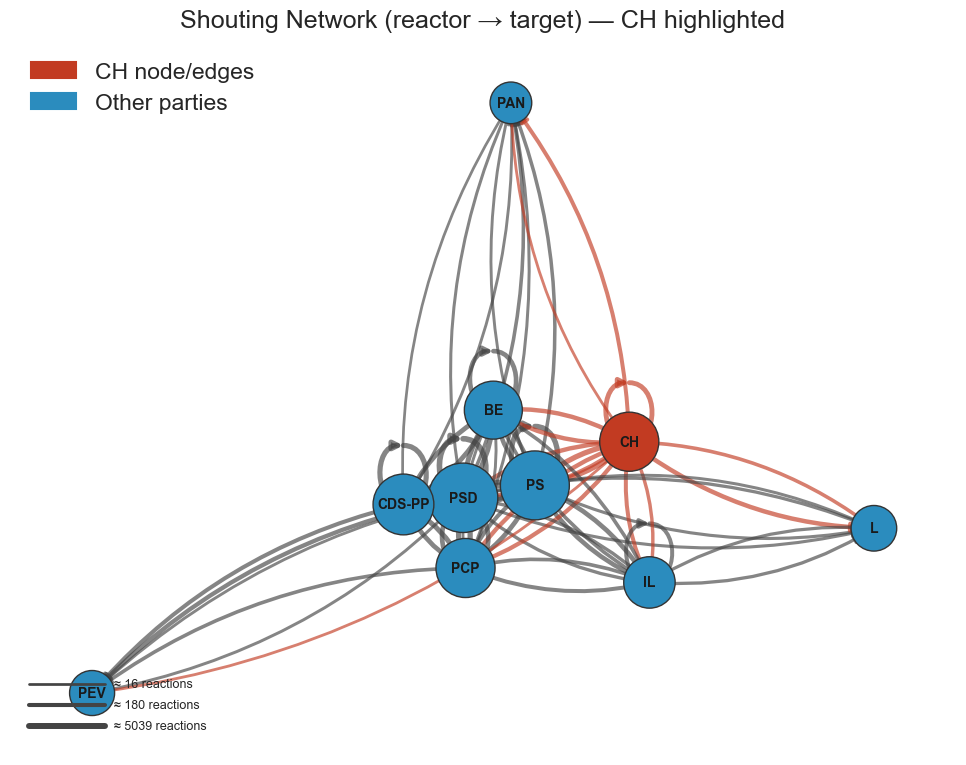

In [ ]:

FOCAL = "CH"                 # highlight Chega
EVENT = "shouting"           # pick 'shouting', 'applause', etc.
MIN_COUNT = 5                # hard filter for very small ties
TOP_K = 80                   # keep top-K heaviest edges after MIN_COUNT

# --- 1) Aggregate edges by event ---
edges = (
    reactions_long[reactions_long["event_type"] == EVENT]
    .groupby(["reacting_party", "speaker_party"], as_index=False)["count"]
    .sum()
)
edges = edges[edges["count"] >= MIN_COUNT]
edges = edges.sort_values("count", ascending=False).head(TOP_K)

# --- 2) Build DiGraph with weights ---
H = nx.DiGraph()
for _, r in edges.iterrows():
    H.add_edge(r["reacting_party"], r["speaker_party"], weight=int(r["count"]))

# drop categories that warp the layout
H.remove_nodes_from([n for n in H.nodes if n in {"OTHER", "UNKNOWN"}])

# --- 3) Layout (weight-aware) ---
pos = nx.spring_layout(H, k=0.55, seed=42, weight="weight")

# --- 4) Node sizes (sqrt scaling of weighted strength) ---
def strength(G, n):
    return sum(d["weight"] for _, _, d in G.out_edges(n, data=True)) + \
           sum(d["weight"] for _, _, d in G.in_edges(n, data=True))

strengths = {n: strength(H, n) for n in H.nodes}
svals = np.array(list(strengths.values()), dtype=float)
sizes = 900 + 1600 * np.sqrt((svals - svals.min()) / (svals.ptp() + 1e-9))

# --- 5) Edge widths (log scaling) and colors (highlight FOCAL ties) ---
w = np.array([d["weight"] for _, _, d in H.edges(data=True)], dtype=float)
w_scaled = 0.8 + 3.5 * (np.log1p(w) / np.log1p(w.max()))
edge_colors = []
for u, v, d in H.edges(data=True):
    if u == FOCAL or v == FOCAL:
        edge_colors.append("#c23b22")    # highlight CH ties
    else:
        edge_colors.append("#444444")    # others

# --- 6) Draw ---
fig, ax = plt.subplots(figsize=(10, 8))

# nodes
node_colors = ["#2b8cbe" if n != FOCAL else "#c23b22" for n in H.nodes]  # red node for CH
nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=node_colors,
                       linewidths=1.0, edgecolors="#333", ax=ax)
nx.draw_networkx_labels(H, pos, font_size=10, font_weight="bold", ax=ax)

# edges (curved to reduce overlap; arrows on)
nx.draw_networkx_edges(
    H, pos,
    width=w_scaled,
    edge_color=edge_colors,
    arrowstyle="-|>",
    arrowsize=12,
    connectionstyle="arc3,rad=0.16",
    alpha=0.65,
    ax=ax
)

# --- 7) Title and legend for edge width meaning ---
ax.set_title(f"{EVENT.capitalize()} Network (reactor → target) — CH highlighted", pad=10)
ax.axis("off")

# simple width legend (min/median/max examples)
if len(w) > 0:
    for val, y in zip([w.min(), np.median(w), w.max()], [0.10, 0.07, 0.04]):
        ax.add_line(plt.Line2D([0.02, 0.10], [y, y],
                               lw=float(0.8 + 3.5 * (np.log1p(val) / np.log1p(w.max()))),
                               color="#444", transform=ax.transAxes))
        ax.text(0.11, y, f"≈ {int(val)} reactions", transform=ax.transAxes, va="center", fontsize=9)

# node legend
patch_focal = mpatches.Patch(color="#c23b22", label=f"{FOCAL} node/edges")
patch_other = mpatches.Patch(color="#2b8cbe", label="Other parties")
ax.legend(handles=[patch_focal, patch_other], loc="upper left", frameon=False)

plt.tight_layout()
plt.show()
